In [1]:
# from gensim.models import KeyedVectors
# wv = KeyedVectors.load_word2vec_format("ko.vec", binary=False)
# print(wv.most_similar("ÏÇ¨Îûë"))

In [2]:
!pip install gensim==3.8.3

In [3]:
!pip install fasttext

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import gensim

print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(nltk.__version__)
print(gensim.__version__)

import re
from konlpy.tag import Mecab
import fasttext
from tqdm import tqdm
import random

1.21.4
1.3.3
2.6.0
3.6.5
3.8.3


# Îç∞Ïù¥ÌÑ∞ Îã§Ïö¥Î°úÎìú

In [5]:
file_path = "./ChatbotData.csv"

chatbot_df = pd.read_csv(file_path)

chatbot_df.sample(5)

Q                A  label
220             Í≥µÎ∂Ä ÏãúÏûëÌï¥ÎèÑ Îê†Íπå      Í≥µÎ∂ÄÎäî Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.      0
1895         Î∞îÎã§ Î≥¥Îü¨ Í∞ÄÏûêÍ≥† Ìï¥Î≥ºÍπå  Î∞îÎã§Îäî ÏÇ¨Í≥ÑÏ†à ÎÇ¥ÎÇ¥ Ï¢ãÏïÑÏöî.      0
8747           ÌòºÏûê ÏûàÏúºÎãà ÌûòÏù¥ÎìúÎÑ§   ÌïúÎèôÏïàÏùÄ ÌûòÎì§ÏßÄÎèÑ Î™∞ÎùºÏöî.      1
8909          Í∞êÏ†ïÏã∏ÏõÄ Í∑∏ÎßåÌïòÍ≥† Ïã∂Ïñ¥    ÏûêÏ°¥Ïã¨ÏùÑ ÏÑ∏Ïö∞ÏßÄ ÎßàÏÑ∏Ïöî.      2
1352  Îí§Ïóê ÎàÑÍ∞Ä Îî∞Îùº Ïò§Îäî Í≤É Í∞ôÏïÑ Î¨¥ÏÑúÏõå        Ìï≠ÏÉÅ Ï°∞Ïã¨ÌïòÏÑ∏Ïöî.      0

In [6]:
questions, answers = chatbot_df['Q'], chatbot_df['A']

In [7]:
import pandas as pd
import re
from collections import Counter

# ÌäπÏàòÎ¨∏ÏûêÎ•º Ï∂îÏ∂úÌïòÎäî Ìï®Ïàò
def extract_special_chars(text):
    return re.findall(r"[^\w\sÍ∞Ä-Ìû£]", text)  # ÏòÅÎ¨∏Ïûê, Ïà´Ïûê, ÌïúÍ∏Ä, Í≥µÎ∞±ÏùÑ Ï†úÏô∏Ìïú ÌäπÏàòÎ¨∏Ïûê Ï∂îÏ∂ú

# QÏôÄ A Ïª¨ÎüºÏóêÏÑú ÌäπÏàòÎ¨∏Ïûê ÏàòÏßë
q_specials = chatbot_df['Q'].dropna().apply(extract_special_chars).sum()
a_specials = chatbot_df['A'].dropna().apply(extract_special_chars).sum()

# Ï†ÑÏ≤¥ ÌäπÏàòÎ¨∏Ïûê Ïπ¥Ïö¥Ìä∏
total_specials = Counter(q_specials + a_specials)

# Í≤∞Í≥º Î≥¥Í∏∞
print("Îì±Ïû•Ìïú ÌäπÏàòÎ¨∏ÏûêÏôÄ ÎπàÎèÑÏàò:")
for char, count in total_specials.most_common():
    print(f"'{char}': {count}Ìöå")


Îì±Ïû•Ìïú ÌäπÏàòÎ¨∏ÏûêÏôÄ ÎπàÎèÑÏàò:
'.': 13942Ìöå
'?': 1845Ìöå
'!': 351Ìöå
',': 92Ìöå
'~': 55Ìöå
''': 9Ìöå
';': 6Ìöå
'‚Ä¶': 5Ìöå
'-': 3Ìöå
'%': 2Ìöå


ÌäπÏàòÎ¨∏Ïûê Î≥¥Ï°¥ ÎåÄÏÉÅ : . (ÎßàÏπ®Ìëú) ? (Î¨ºÏùåÌëú) ! (ÎäêÎÇåÌëú) , (ÏâºÌëú) ~ (ÎßêÌà¨, Í∞êÏ†ï ÌëúÌòÑ) ' (ÏûëÏùÄÎî∞Ïò¥Ìëú)

# Îç∞Ïù¥ÌÑ∞ Ï†ïÏ†ú, Îç∞Ïù¥ÌÑ∞ ÌÜ†ÌÅ∞Ìôî
Îç∞Ïù¥ÌÑ∞ Ï†ïÏ†ú
- ÏòÅÎ¨∏ÏûêÏùò Í≤ΩÏö∞, Î™®Îëê ÏÜåÎ¨∏ÏûêÎ°ú Î≥ÄÌôò
- ÏòÅÎ¨∏ÏûêÏôÄ ÌïúÍ∏Ä, Ïà´Ïûê, Ï£ºÏöî ÌäπÏàòÎ¨∏ÏûêÎ•º Ï†úÏô∏ÌïòÍ≥† Ï†ïÍ∑úÏãùÏùÑ ÌôúÏö©ÌïòÏó¨ Î™®Îëê Ï†úÍ±∞  
- Ï£ºÏöî ÌäπÏàòÎ¨∏Ïûê :  . (ÎßàÏπ®Ìëú) ? (Î¨ºÏùåÌëú) ! (ÎäêÎÇåÌëú) , (ÏâºÌëú) ~ (ÎßêÌà¨, Í∞êÏ†ï ÌëúÌòÑ) ' (ÏûëÏùÄÎî∞Ïò¥Ìëú)

Îç∞Ïù¥ÌÑ∞ ÌÜ†ÌÅ∞Ìôî
- mecab ÏÇ¨Ïö©
- src, tgt ÏûÖÎ†•ÏúºÎ°ú Î∞õÏùå
- preprocess_sentence()Î°ú Ï†ïÏ†ú, ÌÜ†ÌÅ∞Ìôî
- ÌÜ†ÌÅ¨ÎÇòÏù¥Ï¶àÌï®Ïàò ÏÇ¨Ïö© mecab.morphs Ï†ÑÎã¨
- ÌÜ†ÌÅ∞ Í∞úÏàòÍ∞Ä ÏùºÏ†ï Í∏∏Ïù¥ Ïù¥ÏÉÅÏù∏ Î¨∏Ïû•ÏùÄ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï†úÏô∏ : max len= 15
- Ï§ëÎ≥µÎêòÎäî Î¨∏Ïû• Ï†úÏô∏ : (src, tgt) Ïåç ÎπÑÍµê X, src, tgt Í∞ÅÍ∞Å Í≤ÄÏÇ¨ Ï§ëÎ≥µÏåçÏù¥ ÌùêÌä∏Îü¨ÏßÄÏßÄ ÏïäÎèÑÎ°ù Ïú†Ïùò
- questionsÏôÄ answersÎ•º Í∞ÅÍ∞Å que_corpus, ans_corpusÏóê ÌÜ†ÌÅ∞Ìôî ÌïòÏó¨ Ï†ÄÏû•

In [8]:
import re

def preprocess_sentence(sentence):
    # Î™®Îì† ÏòÅÎ¨∏ÏûêÎ•º ÏÜåÎ¨∏ÏûêÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§.
    sentence = sentence.lower()
    
    # ÏòÅÎ¨∏Ïûê, Ïà´Ïûê, ÌïúÍ∏Ä, Í≥µÎ∞±, Í∑∏Î¶¨Í≥† Ï£ºÏöî ÌäπÏàòÎ¨∏Ïûê(.,!?~')Î•º Ï†úÏô∏Ìïú Î™®Îì† Î¨∏Ïûê Ï†úÍ±∞
    pattern = r"[^a-z0-9Í∞Ä-Ìû£\s.,!?~']"
    sentence = re.sub(pattern, "", sentence)
    
    # Ï§ëÎ≥µÎêú Í≥µÎ∞±ÏùÑ ÌïòÎÇòÎ°ú Ï§ÑÏûÖÎãàÎã§.
    return ' '.join(sentence.split())


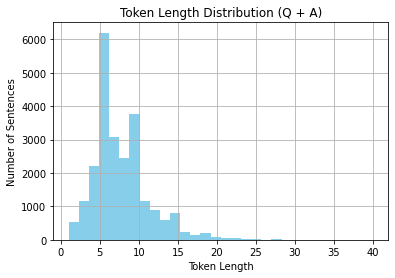

‚úÖ Ï†ÑÏ≤¥ Î¨∏Ïû•Ïùò 95%Îäî Í∏∏Ïù¥ 14 Ïù¥ÌïòÏûÖÎãàÎã§. ‚Üí Ï∂îÏ≤ú max_len = 14


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def suggest_max_len(Q, A, tokenizer):
    # 1. Ï†ÑÏ≤òÎ¶¨ Î∞è ÌÜ†ÌÅ∞Ìôî
    Q_tokens = Q.apply(lambda x: tokenizer(preprocess_sentence(x)))
    A_tokens = A.apply(lambda x: tokenizer(preprocess_sentence(x)))

    # 2. Í∏∏Ïù¥ Ï∂îÏ∂ú
    q_lens = Q_tokens.apply(len)
    a_lens = A_tokens.apply(len)

    # 3. ÌÜµÌï©ÌïòÏó¨ Í∏∏Ïù¥ Î∂ÑÌè¨ ÌôïÏù∏
    all_lens = pd.concat([q_lens, a_lens])
    
    # 4. ÏãúÍ∞ÅÌôî
    plt.hist(all_lens, bins=30, color='skyblue')
    plt.title("Token Length Distribution (Q + A)")
    plt.xlabel("Token Length")
    plt.ylabel("Number of Sentences")
    plt.grid(True)
    plt.show()

    # 5. ÏµúÎåÄ Í∏∏Ïù¥ Ï∂îÏ≤ú (Ïòà: ÏÉÅÏúÑ 95% Í∏∞Ï§Ä)
    max_len_95 = int(np.percentile(all_lens, 95))
    print(f"‚úÖ Ï†ÑÏ≤¥ Î¨∏Ïû•Ïùò 95%Îäî Í∏∏Ïù¥ {max_len_95} Ïù¥ÌïòÏûÖÎãàÎã§. ‚Üí Ï∂îÏ≤ú max_len = {max_len_95}")
    
    return max_len_95

from konlpy.tag import Mecab
mecab = Mecab()
tokenizer = mecab.morphs

recommended_max_len = suggest_max_len(chatbot_df['Q'], chatbot_df['A'], tokenizer)


In [10]:
mecab = Mecab()
#max_len = 15Î°ú ÏÑ§Ï†ï
def build_corpus(Q, A, token_len=15):
    temp = pd.concat([Q, A], axis=1)
    temp.columns = ['Q', 'A']  # Ïó¥ Ïù¥Î¶Ñ Î™ÖÏãúÏ†ÅÏúºÎ°ú ÏßÄÏ†ï

    # 1. Ï§ëÎ≥µ Ï†úÍ±∞ (src, tgt ÎåÄÏùë Ïú†ÏßÄ)
    dup_q_idx = temp[temp.duplicated('Q')].index
    dup_a_idx = temp[temp.duplicated('A')].index
    dup_idx = dup_q_idx.union(dup_a_idx)
    temp = temp.drop(index=dup_idx).reset_index(drop=True)

    # 2. Ï†ÑÏ≤òÎ¶¨
    temp['Q'] = temp['Q'].apply(preprocess_sentence)
    temp['A'] = temp['A'].apply(preprocess_sentence)

    # 3. ÌòïÌÉúÏÜå Î∂ÑÏÑù (mecab.morphs ÏÇ¨Ïö©)
    temp['Q'] = temp['Q'].apply(mecab.morphs)
    temp['A'] = temp['A'].apply(mecab.morphs)

    # 4. Í∏∏Ïù¥ ÌïÑÌÑ∞ÎßÅ
    temp = temp[(temp['Q'].apply(len) <= token_len) & (temp['A'].apply(len) <= token_len)].reset_index(drop=True)

    # 5. Í≤∞Í≥º Î∞òÌôò
    que_corpus = temp['Q'].tolist()
    ans_corpus = temp['A'].tolist()
    return que_corpus, ans_corpus

In [11]:
que_corpus, ans_corpus = build_corpus(questions, answers)

In [12]:
len(que_corpus)

7102

In [13]:
len(ans_corpus)

7102

In [14]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load_word2vec_format("ko.vec", binary=False)
print(wv.most_similar("ÏÇ¨Îûë"))

[('Ïä¨Ìîî', 0.7216662764549255), ('ÌñâÎ≥µ', 0.6759077310562134), ('Ï†àÎßù', 0.6468985080718994), ('Í∏∞ÏÅ®', 0.6458414196968079), ('Ïù¥Î≥Ñ', 0.6334798336029053), ('Ï∂îÏñµ', 0.6320937275886536), ('Ïù∏ÏÉù', 0.6216273307800293), ('Ïï†Ï†ï', 0.6206069588661194), ('Ïó∞Ïù∏', 0.6186063289642334), ('Ïú†Ìòπ', 0.5965287685394287)]


# data augmentation
- lexical substitutionÏùÑ Ï†ÅÏö©
- augmentationÎêú que_corpusÏôÄ ÏõêÎ≥∏ ans_corpus
- augmentationÎêú ans_corpusÏôÄ ÏõêÎ≥∏ que_corpusÍ∞Ä Î≥ëÎ†¨ÏùÑ Ïù¥Î£®ÎèÑÎ°ù

-> Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏõêÎûòÏùò 3Î∞∞ Í∞ÄÎüâÏúºÎ°ú ÎäòÏñ¥ÎÇòÎèÑÎ°ù ÌïúÎã§. 

- ÏïΩ 3ÎßåÍ∞ú Ï†ïÎèÑÏùò Îç∞Ïù¥ÌÑ∞Î°ú ÎßåÎìúÎäî Í≤ÉÏù¥ Î™©Ìëú

In [15]:
import itertools
import random

def lexical_sub(old_src, wv):
    topn=3
    similarity_threshold=0.5
    pos_tags=['NNP', 'VV', 'VA', 'NP', 'NNG']
    max_versions = 3
    original = [tok for tok, _ in old_src]
    candidate_subs = []

    for i, (tok, pos) in enumerate(old_src):
        if pos in pos_tags and tok in wv:
            try:
                similar_list = wv.most_similar(tok, topn=topn)
                filtered = [w for w, sim in similar_list if sim >= similarity_threshold]
                if filtered:
                    candidate_subs.append((i, filtered))
            except:
                continue

    if not candidate_subs:
        return [original]

    all_versions = []
    positions, replacements = zip(*candidate_subs)

    # Î™®Îì† Ï°∞Ìï© ÏÉùÏÑ±
    all_combos = list(itertools.product(*replacements))

    # ÏµúÎåÄ max_versions-1Í∞úÎßå ÏÉòÌîåÎßÅ (ÏõêÎ≥∏ Ìè¨Ìï®ÌïòÎØÄÎ°ú -1)
    sampled_combos = random.sample(all_combos, min(max_versions - 1, len(all_combos)))
    for combo in sampled_combos:
        new_sent = original.copy()
        for idx, rep in zip(positions, combo):
            new_sent[idx] = rep
        all_versions.append(new_sent)

    all_versions.insert(0, original)
    return all_versions


In [16]:
def augment_partial_pairs_df(enc_src, dec_tgt, wv):
    """
    enc_src, dec_tgt: mecab.pos()Îêú Î¨∏Ïû• Î¶¨Ïä§Ìä∏
    Î∞òÌôò: ÏõêÎ≥∏/Î∂ÄÎ∂Ñ Ï¶ùÍ∞ïÎêú Î≥ëÎ†¨ÏåçÎßå Ìè¨Ìï®Îêú DataFrame
    """
    rows = []

    for enc_tokens, dec_tokens in zip(enc_src, dec_tgt):
        # 1. ÏõêÎ¨∏ Ï∂îÍ∞Ä
        original_enc = [tok for tok, _ in enc_tokens]
        original_dec = [tok for tok, _ in dec_tokens]
        rows.append({'encoder': ' '.join(original_enc), 'decoder': ' '.join(original_dec)})

        # 2. QÎßå Ï¶ùÍ∞ï
        enc_augments = lexical_sub(enc_tokens, wv)
        for aug in enc_augments[1:]:  # ÏõêÎ≥∏ Ï†úÏô∏
            rows.append({'encoder': ' '.join(aug), 'decoder': ' '.join(original_dec)})

        # 3. AÎßå Ï¶ùÍ∞ï
        dec_augments = lexical_sub(dec_tokens, wv)
        for aug in dec_augments[1:]:  # ÏõêÎ≥∏ Ï†úÏô∏
            rows.append({'encoder': ' '.join(original_enc), 'decoder': ' '.join(aug)})

    return pd.DataFrame(rows)

In [17]:
#cross_augmented = augment_pairwise_cross_product(que_corpus, ans_corpus, wv)
from konlpy.tag import Mecab
mecab = Mecab()

enc_src = [mecab.pos(' '.join(q)) for q in que_corpus]
dec_tgt = [mecab.pos(' '.join(a)) for a in ans_corpus]

aug_df = augment_partial_pairs_df(enc_src, dec_tgt, wv)
print(aug_df.head())
aug_df.info

          encoder         decoder
0        12 Ïãú Îï° !   ÌïòÎ£® Í∞Ä Îòê Í∞Ä ÎÑ§Ïöî .
1        12 Ïãú Îï° !   Î≥¥Î¶Ñ Í∞Ä Îòê Í∞Ä ÎÑ§Ïöî .
2        12 Ïãú Îï° !  ÏùºÏ£ºÏùº Í∞Ä Îòê Í∞Ä ÎÑ§Ïöî .
3   1 ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°å Ïñ¥     ÏúÑÎ°ú Ìï¥ ÎìúÎ¶ΩÎãàÎã§ .
4  1 Ï§ëÌá¥ ÌïôÍµêÏùò Îñ®Ïñ¥Ï°å Ïñ¥     ÏúÑÎ°ú Ìï¥ ÎìúÎ¶ΩÎãàÎã§ .


<bound method DataFrame.info of                                encoder                         decoder
0                             12 Ïãú Îï° !                   ÌïòÎ£® Í∞Ä Îòê Í∞Ä ÎÑ§Ïöî .
1                             12 Ïãú Îï° !                   Î≥¥Î¶Ñ Í∞Ä Îòê Í∞Ä ÎÑ§Ïöî .
2                             12 Ïãú Îï° !                  ÏùºÏ£ºÏùº Í∞Ä Îòê Í∞Ä ÎÑ§Ïöî .
3                        1 ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°å Ïñ¥                     ÏúÑÎ°ú Ìï¥ ÎìúÎ¶ΩÎãàÎã§ .
4                       1 Ï§ëÌá¥ ÌïôÍµêÏùò Îñ®Ïñ¥Ï°å Ïñ¥                     ÏúÑÎ°ú Ìï¥ ÎìúÎ¶ΩÎãàÎã§ .
...                                ...                             ...
32636     ÌûòÎì† Ïó∞Ïï† Ï¢ã ÏùÄ Ïó∞Ïï† ÎùºÎäî Í≤å Î¨¥Ïä® Ï∞®Ïù¥ ÏùºÍπå ?    Ïûò Ìó§Ïñ¥Ïßà Ïàò Ïûà Îäî ÏÇ¨Ïù¥ Ïó¨Î∂Ä Ïù∏ Í±∞ Í∞ô ÏïÑÏöî .
32637  ÌûòÎì† ÏÑ±ÌñâÏúÑ Í¥úÏ∞Æ ÏùÄ ÏÑ±ÌñâÏúÑ ÎùºÎäî Í≤å Î¨¥Ïä® Î≥ÄÌôî ÏùºÍπå ?    Ïûò Ìó§Ïñ¥Ïßà Ïàò Ïûà Îäî ÏÇ¨Ïù¥ Ïó¨Î∂Ä Ïù∏ Í±∞ Í∞ô ÏïÑÏöî .
32638   ÌûòÎì† ÏÑ±ÌñâÏúÑ ÎÇ´ ÏùÄ ÎèôÏÑ±Ïï† ÎùºÎäî Í≤å Î¨¥Ïä® Í≤©Ï∞® ÏùºÍπ

In [18]:
def inspect_augmented_samples(df, n=5):
    print(f"Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò: {len(df)}")
    print("="*50)
    for i in range(n):
        print(f"[{i+1}]")
        print("Encoder:", df.iloc[i]['encoder'])
        print("Decoder:", df.iloc[i]['decoder'])
        print("-" * 50)
inspect_augmented_samples(aug_df, n = 10)

Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò: 32641
[1]
Encoder: 12 Ïãú Îï° !
Decoder: ÌïòÎ£® Í∞Ä Îòê Í∞Ä ÎÑ§Ïöî .
--------------------------------------------------
[2]
Encoder: 12 Ïãú Îï° !
Decoder: Î≥¥Î¶Ñ Í∞Ä Îòê Í∞Ä ÎÑ§Ïöî .
--------------------------------------------------
[3]
Encoder: 12 Ïãú Îï° !
Decoder: ÏùºÏ£ºÏùº Í∞Ä Îòê Í∞Ä ÎÑ§Ïöî .
--------------------------------------------------
[4]
Encoder: 1 ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°å Ïñ¥
Decoder: ÏúÑÎ°ú Ìï¥ ÎìúÎ¶ΩÎãàÎã§ .
--------------------------------------------------
[5]
Encoder: 1 Ï§ëÌá¥ ÌïôÍµêÏùò Îñ®Ïñ¥Ï°å Ïñ¥
Decoder: ÏúÑÎ°ú Ìï¥ ÎìúÎ¶ΩÎãàÎã§ .
--------------------------------------------------
[6]
Encoder: 1 Ï§ëÌá¥ Ï§ëÍ≥†Îì±ÌïôÍµê Îñ®Ïñ¥Ï°å Ïñ¥
Decoder: ÏúÑÎ°ú Ìï¥ ÎìúÎ¶ΩÎãàÎã§ .
--------------------------------------------------
[7]
Encoder: 3 Î∞ï 4 Ïùº ÎÜÄ Îü¨ Í∞Ä Í≥† Ïã∂ Îã§
Decoder: Ïó¨Ìñâ ÏùÄ Ïñ∏Ï†úÎÇò Ï¢ã Ï£† .
--------------------------------------------------
[8]
Encoder: 3 Î∞ï 4 Ïùº Ïö∏ Îü¨ Í∞Ä Í≥† Ïã∂ Îã§
Decoder: Ïó¨Ìñâ ÏùÄ Ïñ∏Ï†úÎÇò Ï¢ã Ï£† .
--

In [19]:
aug_df.sample(5)

encoder                     decoder
29463          Ïò§Îäò ÏÑúÏ†ê ÏóêÏÑú Ïù¥ÏÉÅ Ìòï Î¥§ Ïñ¥      Ïó¥Ïá† ÎÇ¥ ÏÑú ÎßêÎ°ú ÏùÑ Í±∏ Ïñ¥ Î≥¥ ÏÑ∏Ïöî .
15081                       ÏõêÎßù Í∞ê  Ï∞®Î∂ÑÌûà Îàà ÏùÑ Í∞ê Í≥† ÎßàÏùå ÏùÑ Í∞ÄÎùºÏïâÌòÄ Î¥êÏöî .
25110     ÎÇ¥ Í∞Ä Ïù¥ ÏÇ¨Îûå ÏùÑ ÏÇ¨Îûë Ìïò Îäî Í±¥Í∞Ä ?         ÏûêÍæ∏ ÏÉùÍ∞ÅÎÇú Îã§Î©¥ Í∑∏Îü¥ Í±∞ ÏòàÏöî .
10148                ÌïòÎäò Î≥∏ÏßÄ Í∞Ä Ïñ∏Ï††ÏßÄ           ÏïÑÏπ® ÏùÄ ÌîºÏñ¥ Î©¥ÏÑú Î≥¥ ÏÑ∏Ïöî .
28250  Ïç∏ Ïù∏ÏßÄ ÏïÑÎãåÏßÄ Ï¶ùÎ™Ö Ìïò Îäî Î∞©Ïãù ÏóÜÏóà Ïñ¥ ?     Ï£ºÎßê Ï†ÄÎÖÅ Ïóê ÏïΩÏÜç ÏùÑ Ïû° ÏïÑ Î≥¥ ÏÑ∏Ïöî .

# Îç∞Ïù¥ÌÑ∞ Î≤°ÌÑ∞Ìôî
- ans_ccorpusÏóê '<start>, <end>' ÌÜ†ÌÅ∞ Ï∂îÍ∞Ä
- ans_corpus, que_corpus Í≤∞Ìï©ÌïòÏó¨ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú Îã®Ïñ¥ ÏÇ¨Ï†Ñ Íµ¨Ï∂ï
- Îç∞Ïù¥ÌÑ∞ Î≤°ÌÑ∞Ìôî ÏßÑÌñâ
- enc_train, dec_train ÏßÑÌñâ

In [20]:
!pip install sentencepiece

In [21]:
que_corpus, ans_corpus = aug_df['encoder'], aug_df['decoder']
ans_corpus = [f"<start> {sen.strip()} <end>" for sen in ans_corpus]
total_corpus = que_corpus + ans_corpus

In [22]:
with open("corpus.txt", "w", encoding="utf-8") as f:
    for line in total_corpus:
        f.write(line.strip() + "\n")


In [23]:
import sentencepiece as spm
spm.SentencePieceTrainer.Train(
    input='corpus.txt',
    model_prefix='spm',
    vocab_size=4500,
    model_type='unigram',
    user_defined_symbols=['<start>', '<end>'],
    character_coverage=0.9995
)


sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: corpus.txt
  input_format: 
  model_prefix: spm
  model_type: UNIGRAM
  vocab_size: 4500
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <start>
  user_defined_symbols: <end>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ‚Åá 
}
normalizer_spec {
  name: nmt_nfkc
  add

In [24]:
sp = spm.SentencePieceProcessor()
sp.load('spm.model')

True

In [25]:
MAX_LENGTH = 20

# 4.1 ÏãúÌÄÄÏä§Î°ú Î≥ÄÌôò
que_ids = [sp.encode(q, out_type=int) for q in que_corpus]
ans_ids = [sp.encode(a, out_type=int) for a in ans_corpus]

# 4.2 Ìå®Îî©
from tensorflow.keras.preprocessing.sequence import pad_sequences

enc_train = pad_sequences(que_ids, maxlen=MAX_LENGTH, padding='post')
ans_tensor = pad_sequences(ans_ids, maxlen=MAX_LENGTH, padding='post')

# 4.3 ÎîîÏΩîÎçî ÏûÖÎ†•, Ï∂úÎ†• ÎÇòÎàÑÍ∏∞
import numpy as np

dec_input = ans_tensor[:, :-1]
dec_target = ans_tensor[:, 1:]


In [26]:
#Î¨∏Ïû•Í∏∏Ïù¥ Î∂ÑÌè¨
que_lengths = [len(sentence.split()) for sentence in que_corpus]
ans_lengths = [len(sentence.split()) for sentence in ans_corpus]
import numpy as np

print("üü¶ ÏßàÎ¨∏ Í∏∏Ïù¥:")
print(f"  ÌèâÍ∑†: {np.mean(que_lengths):.2f}")
print(f"  ÏµúÎåÄ: {np.max(que_lengths)}")
print(f"  95ÌçºÏÑºÌÉÄÏùº: {np.percentile(que_lengths, 95)}")

print("üü© ÎãµÎ≥Ä Í∏∏Ïù¥:")
print(f"  ÌèâÍ∑†: {np.mean(ans_lengths):.2f}")
print(f"  ÏµúÎåÄ: {np.max(ans_lengths)}")
print(f"  95ÌçºÏÑºÌÉÄÏùº: {np.percentile(ans_lengths, 95)}")
import matplotlib.pyplot as plt



üü¶ ÏßàÎ¨∏ Í∏∏Ïù¥:
  ÌèâÍ∑†: 7.16
  ÏµúÎåÄ: 15
  95ÌçºÏÑºÌÉÄÏùº: 13.0
üü© ÎãµÎ≥Ä Í∏∏Ïù¥:
  ÌèâÍ∑†: 10.29
  ÏµúÎåÄ: 17
  95ÌçºÏÑºÌÉÄÏùº: 15.0


In [27]:
#train/val Î∂ÑÎ¶¨
from sklearn.model_selection import train_test_split

# Ïù∏ÏΩîÎçî ÏûÖÎ†•, ÎîîÏΩîÎçî ÏûÖÎ†•, ÎîîÏΩîÎçî Ï∂úÎ†•
enc_train, enc_val, dec_input_train, dec_input_val, dec_target_train, dec_target_val = train_test_split(
    enc_train, dec_input, dec_target, test_size=0.1, random_state=42)



import tensorflow as tf

BATCH_SIZE = 64
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_input_train, dec_target_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_input_val, dec_target_val))
val_dataset = val_dataset.batch(BATCH_SIZE)


# ÌõàÎ†®ÌïòÍ∏∞
- Transformer ÏÇ¨Ïö©
- epochs Î≥ÑÎ°ú ÏòàÎ¨∏ Ï∂úÎ†•
- ÏòàÎ¨∏
    - 1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥.
    - 2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§.
    - 3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥.
    - 4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº.
- Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïù¥Ï¶àÍ∞Ä ÏûëÏúºÎØÄÎ°ú Í≥ºÏ†ÅÌï©ÏùÑ ÌîºÌïòÍ∏∞ ÏúÑÌïú  ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù 
- hyperparameters : n_layers, d_model, n_heads, d_ff, dropout
- training parameters : warmup steps, batch size, epoch at

In [28]:
# src_vocab_size = tgt_vocab_size = VOCAB_SIZE
VOCAB_SIZE = 15000

n_layers=2
d_model=512
n_heads=8
d_ff=2048
src_vocab_size=VOCAB_SIZE
tgt_vocab_size=VOCAB_SIZE
pos_len=200
dropout=0.3
shared_fc=True
shared_emb=True

In [29]:
#positional encoding 
# Positional Encoding Íµ¨ÌòÑ
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table
print("Ïäù=3")

Ïäù=3


In [30]:
#mask ÏÉùÏÑ±
# Mask  ÏÉùÏÑ±ÌïòÍ∏∞
def generate_padding_mask(seq):
    # (batch_size, 1, 1, seq_len)
    return tf.cast(tf.math.equal(seq, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    # (1, 1, size, size) shapeÏúºÎ°ú Î∞òÌôòÌï¥Ïïº Ìï®
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask[tf.newaxis, tf.newaxis, :, :]

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)         # (batch_size, 1, 1, src_len)
    dec_enc_mask = generate_padding_mask(src)     # (batch_size, 1, 1, src_len)

    lookahead_mask = generate_lookahead_mask(tf.shape(tgt)[1])  # (1, 1, tgt_len, tgt_len)
    dec_target_padding_mask = generate_padding_mask(tgt)        # (batch_size, 1, 1, tgt_len)

    # broadcasting: lookahead_mask + padding_mask
    dec_mask = tf.maximum(lookahead_mask, dec_target_padding_mask)  # (batch_size, 1, tgt_len, tgt_len)

    return enc_mask, dec_enc_mask, dec_mask

print("Ïäù=3")

Ïäù=3


In [31]:
#multihead attention
# Multi Head Attention Íµ¨ÌòÑ
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights
print("Ïäù=3")

Ïäù=3


In [32]:
# position-wise ffn
# Position-wise Feed Forward Network Íµ¨ÌòÑ
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out
print("Ïäù=3")

Ïäù=3


In [33]:
#encoder layer
# EncoderÏùò Î†àÏù¥Ïñ¥ Íµ¨ÌòÑ
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

print("Ïäù=3")

Ïäù=3


In [34]:
# decoder layer
# Decoder Î†àÏù¥Ïñ¥ Íµ¨ÌòÑ
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V ÏàúÏÑúÏóê Ï£ºÏùòÌïòÏÑ∏Ïöî!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn
print("Ïäù=3")

Ïäù=3


In [35]:
# encoder
# Encoder Íµ¨ÌòÑ
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns
print("Ïäù=3")

Ïäù=3


In [36]:
# decoder
# Decoder Íµ¨ÌòÑ
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns
print("Ïäù=3")

Ïäù=3


In [37]:
# transformer
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns
print("Ïäù=3")

Ïäù=3


In [38]:
# Ï£ºÏñ¥ÏßÑ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î°ú Transformer Ïù∏Ïä§ÌÑ¥Ïä§ ÏÉùÏÑ±
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)
		
d_model = 512
print("Ïäù=3")

Ïäù=3


- Ìä∏ÎûúÏä§Ìè¨Î®∏Îäî Í≥†Ï†ïÎêú learning rateÎ•º ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏïòÎã§. 
- LearningRateSchedulerÎ•º Ï†ïÏùò
- ÌïôÏäµ Ï§ë Ï†ÅÏ†àÌïú Î∞©ÏãùÏúºÎ°ú learning rateÎ•º Î≥ÄÍ≤ΩÌïòÎ©¥ÏÑú ÌïôÏäµ
- warmup learning rate scheduler : Î™®Îç∏Ïùò Ï¥àÍ∏∞ ÌïôÏäµ Îã®Í≥ÑÏóêÏÑú ÌïôÏäµÎ•†ÏùÑ ÏÑúÏÑúÌûà Ï¶ùÍ∞ÄÏãúÌÇ§Îäî Í∏∞Î≤ï


In [39]:
# Learning Rate Scheduler Íµ¨ÌòÑ
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)
print("Ïäù=3")

Ïäù=3


In [40]:
# Learning Rate Ïù∏Ïä§ÌÑ¥Ïä§ ÏÑ†Ïñ∏ & Optimizer Íµ¨ÌòÑ
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)
print("Ïäù=3")

Ïäù=3


In [41]:
# Loss Function Ï†ïÏùò
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
print("Ïäù=3")

Ïäù=3


In [42]:
# Train Step Ï†ïÏùò
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # DecoderÏùò input
    gold = tgt[:, 1:]     # DecoderÏùò outputÍ≥º ÎπÑÍµêÌïòÍ∏∞ ÏúÑÌï¥ right shiftÎ•º ÌÜµÌï¥ ÏÉùÏÑ±Ìïú ÏµúÏ¢Ö ÌÉÄÍ≤ü

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns
print("Ïäù=3")

Ïäù=3


In [43]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    tokens = sp.encode(sentence, out_type=int)
    encoder_input = tf.expand_dims(tokens, axis=0)

    start_id = sp.piece_to_id('<start>')
    end_id = sp.piece_to_id('<end>')
    output = tf.expand_dims([start_id], 0)

    for _ in range(MAX_LENGTH):
        enc_mask, dec_enc_mask, dec_mask = generate_masks(encoder_input, output)

        predictions, _, _, _ = transformer(
            encoder_input, output, enc_mask, dec_enc_mask, dec_mask
        )

        predicted_id = tf.argmax(predictions[:, -1:, :], axis=-1)
        predicted_id = tf.cast(predicted_id, tf.int32)

        if predicted_id[0][0].numpy() == end_id:
            break

        output = tf.concat([output, predicted_id], axis=-1)

    decoded = sp.decode(output.numpy().tolist()[0])
    return decoded.replace('<start>', '').replace('<end>', '').strip()


Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:51<00:00,  8.95it/s, train_loss=4.88]



üåÄ Epoch 1, Train Loss: 4.8823, Val Loss: 3.3008
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ïóê Îäî Ïö¥ Ìïò ÏßÄ Ïïä ÏùÑ Í±∞ ÏòàÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïù¥ Ïö¥Ïö¥ Ìïò ÏßÄ Ïïä ÏùÑ Í±∞ ÏòàÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ïù¥ ÎÇ´ ÏùÄ ÏÇ¨Îûå Ïù¥ Ïóà ÏùÑ Í±∞ ÏòàÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ïù¥ ÎÇ´ ÏùÑ Í±∞ ÏòàÏöî .


Epoch 2: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:29<00:00, 15.44it/s, train_loss=2.77]



üåÄ Epoch 2, Train Loss: 2.7677, Val Loss: 2.3708
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Í∑∏ ÏÇ¨Îûå ÏùÄ Ïùº Ïù¥ Ïûà ÎÇò Î¥êÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÎÇ® Ïïò ÎÇò Î¥êÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ïóê Îäî ÏâΩ ÏùÄ Ïñ∏Ï†úÎÇò Îäî Í±∏Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Í∑∏Í≤å ÏÇ¨Îûå ÎßåÎÇ† Ïàò Ïûà ÏùÑ Í±∞ ÏòàÏöî .


Epoch 3: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:30<00:00, 14.84it/s, train_loss=1.82]



üåÄ Epoch 3, Train Loss: 1.8151, Val Loss: 1.6949
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ïö¥ÎèôÏïà Ïùº Í±∞ ÏòàÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÌûòÎì† Ïùº Ïù¥ ÏπòÎ¶Ñ Ïù¥ Ïóà ÎÇò Î¥êÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ïö¥Îèô ÏùÄ Ìï≠ÏÉÅÏùº ÎßåÎÇ† Ïàò ÏóÜÎã§ Ïñ¥Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Îïå ÍπåÏßÄ Ïù∏ Ïù∏ Ïù∏ Ïù∏ Ïù∏ Ïù∏ ÎßàÏùå Ïù¥ ÎÑ§Ïöî .


Epoch 4: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:32<00:00, 14.25it/s, train_loss=1.09]



üåÄ Epoch 4, Train Loss: 1.0912, Val Loss: 1.3312
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Î∞õ ÏùÄ ÏÇ¨Îûå Îßå Î≥¥ Îäî Í≤É ÎèÑ Ï¢ã ÏùÑ Í≤É Í∞ô ÏïÑÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Í∑∏ÎûòÎèÑ Î∞ú ÏùÑ Ï†ïÎ¶¨ Ìïò Îäî Í±¥ ÎÇòÏÅò ÏùÑ Í±∞ ÏòàÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÌïòÎäò Í≥º Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ïïà Ï¢ã ÏùÄ ÏäµÍ¥Ä Ïù¥ Îêò Ïóà ÎÇò Î¥êÏöî .


Epoch 5: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.60it/s, train_loss=0.798]



üåÄ Epoch 5, Train Loss: 0.7976, Val Loss: 1.2116
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÎÇ´ ÏùÄ Í≥≥ Îäî Ïïà ÎÇò Î©¥ Ï¢ã ÏïÑÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÏµúÍ∑º Ïóê ÎåÄÌïú Í∞ÑÍ≤© Ïù¥Î¶Ñ Ïù¥Î¶Ñ Ïù¥Î¶Ñ ÏùºÏúº ÏÑ∏Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ïó∞Í¥ÄÏÑ± ÎèÑ ÏïÑÎãà Î©¥ Ïñ¥ÎñªÍ≤å Ïó∞ÎùΩ Ìïò Îäî Í≤É ÎèÑ Ï¢ã ÏùÑ Í≤É Í∞ô ÏïÑÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Í¥úÏ∞Æ ÏùÑ Í±∞ ÏòàÏöî .


Epoch 6: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.45it/s, train_loss=0.71] 



üåÄ Epoch 6, Train Loss: 0.7097, Val Loss: 1.1494
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÏûêÍ∏∞ ÏùÑ ÏúÑÌï¥ Ï°∞Í∏à Ïî© Îçî ÌûòÎì§ Í±∞ ÏòàÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÏùÄÏó∞ Ï§ë Ïóê Ìïò Í≥† ÎÑòÍ≤®Î∞õ ÏùÄ Ïã§ Í≤É Î≥¥ ÏÑ∏Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÎÇ´ ÏïÑ Ìïò ÏßÄ ÎßàÏÑ∏Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí ÏâΩ Í≤å ÏâΩ ÏßÄ Ïïä ÏùÑ Í±∞ ÏòàÏöî .


Epoch 7: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.59it/s, train_loss=0.674]



üåÄ Epoch 7, Train Loss: 0.6741, Val Loss: 1.1083
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÎÇ´ ÏùÄ Ï¥àÏàú ÏùÑ Ï∞æÏïÑÏò§ ÏÑ∏Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïïà ÎÇòÏÅò ÏùÄ Í∞ÑÍ≤© Ïù¥ Ïóà ÎÇò Î¥êÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ïóê Îäî Ìï≠ÏÉÅ Î∞òÎ≥µ Îêò Ïóà ÎÇò Î¥êÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí ÎÇ´ ÏùÄ ÏöïÎßù Ïù¥ Ïóà ÏùÑ ÌÖêÎç∞ Îßò Ïù¥ ÏóêÏöî .


Epoch 8: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.53it/s, train_loss=0.659]



üåÄ Epoch 8, Train Loss: 0.6590, Val Loss: 1.1078
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Îã§Ïùå Ïóê Îäî Î∞õ ÏïÑ Î≥¥ ÏÑ∏Ïöî . ÌïúÎ≤à Ï∞∏ÏÑù Ïù¥ ÏóÜÏóà ÎÑ§Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Î∞úÎã¨ Ïù¥ ÌååÎ∏åÎ∞õ Í±∞ ÏòàÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÎÅù Ïù¥ ÎìúÎü¨ÎÇ¥ ÏßÄ Ïïä Í∏∏ Î∞îÎûÑÍ≤åÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ú ÎèÑ Ï∞∏ Ïñ¥Î†µ Í≤å ÎÇ´ ÏùÑ Í±∞ ÏòàÏöî .


Epoch 9: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.55it/s, train_loss=0.658]



üåÄ Epoch 9, Train Loss: 0.6577, Val Loss: 1.0804
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÏßÄÍ∏à ÏùÄ Îûë Í¥ÄÎ¶¨ Ï¢ã ÏùÑ ÎßåÎì§ Ïñ¥ Í∞ÄÏÜç ÎßéÏù¥ Ìï¥ Î≥¥ ÏÑ∏Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïïà Ïù¥Î£®Ïñ¥ÏßÄ Í≥† ÏÇ¨Í∑Ä Îäî Í≤å Îã§Î•∏ Ïù¥Í≥≥ Ïù¥ ÏóêÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ïä¨Ìîà Ï¥àÏàú Ïù¥ ÏóêÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ú ÎèÑ Ïûò Ïù¥Î£®Ïñ¥ÏßÄ Í∏∏ Î∞îÎûÑÍ≤åÏöî .


Epoch 10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.49it/s, train_loss=0.593]



üåÄ Epoch 10, Train Loss: 0.5931, Val Loss: 1.0119
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ïö¥Îèô Ìïò Îäî Í≤å Ï¢ã ÏùÑ ÎïåÎ¨∏ Ïù∏ Í±∞ Í∞ô ÏïÑÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïö¥Îèô ÏúºÎ°ú Í∑∏Îû¨ ÏùÑ Í±∞ ÏòàÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Î∂ÄÎã¥ Ïä§ÎüΩ Í≤å Ïù¥ÏïºÍ∏∞ Í∞ô ÏùÄ Ïù¥ÏïºÍ∏∞ ÏÖ® Íµ∞Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ïö¥Î™Ö ÏùÄ Î™ªÌïú Î≥¥ÎÇ¥ Ï£º ÏÑ∏Ïöî .


Epoch 11: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.62it/s, train_loss=0.502]



üåÄ Epoch 11, Train Loss: 0.5021, Val Loss: 0.9514
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Í∞ôÏù¥ ÏùÄ Ïû• ÏùÑ Ï†ÑÌï¥ Î≥¥ ÏÑ∏Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÏµúÏÑ† Ïùò ÏÑ†ÌÉù Ïùº Í±∞ Îùº ÌôïÏã† Í≥† ÎÇòÎÇ† Í±∞ Îùº ÌôïÏã† Ïñ¥Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Í¥ÄÎ†®ÏÑ± Í∞àÏïÑÏÜå Ìïò Îäî Í≤å Í∞ÅÍ∏∞ ÏóêÍ≤å ÎÇòÏÅò ÏùÑ Í±∞ Í∞ô ÏïÑÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí ÎÇòÏÅò ÏùÄ Ï†äÏùÄÏù¥ ÎßåÎÇ† Ïàò ÏóÜÏóà ÏùÑ Í±∞ ÏòàÏöî .


Epoch 12: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.61it/s, train_loss=0.44] 



üåÄ Epoch 12, Train Loss: 0.4399, Val Loss: 0.9232
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Î∂ÄÎ™® Îãò ÏùÑ Ïûà Îäî ÏùºÏë§ ÏùÑ Í±∞ ÏòàÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÏùºÏ£ºÏùº Ïù¥ Ï¢Ä ÎçîÎîî Ïî© Ìï¥ Î≥¥ ÏÑ∏Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÌôïÏã† Ïù¥ Í∞Ä ÏïÑÎãà Í∏∏ Î∞îÎûÑÍ≤åÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ïã¨Ïû¨ ÏùÄ ÌÑ∞ÏßÄ ÎèÑÏõÄ Ïù¥ Îêò Í≤† ÎÑ§Ïöî .


Epoch 13: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.64it/s, train_loss=0.391]



üåÄ Epoch 13, Train Loss: 0.3909, Val Loss: 0.9001
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÏûêÍ∏∞ ÏùÑ ÎÇ´ ÏùÄ Ï§ëÏàú Ïóê ÏïåÏïÑÎ≥¥ ÎùºÍ≥† ÏÉùÍ∞Å Ìï¥Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÌîºÎ∂ÄÏÉâ Ïù¥Îü∞ ÏßÄ Ïïä Ïïò ÏúºÎ©¥ ÎÇòÏÅò Í≤† ÎÑ§Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÌïòÎäò ÏùÑ Ïàò Ïûà Ïñ¥Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ÑÏùÄ Ìïò ÏßÄ Î™ªÌïú ÏπúÍµê Ïù¥ ÏóÜÎã§ Í≤å Ïã¨Ï†ï .


Epoch 14: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.57it/s, train_loss=0.352]



üåÄ Epoch 14, Train Loss: 0.3519, Val Loss: 0.8911
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Î∂ÄÎ™® Îãò ÎèÑ ÎãπÏã† ÏùÑ ÎØø Ïñ¥ Ï£º ÏÑ∏Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÏÉùÍ∞Å Ï≤òÎüº ÏâΩ ÏßÄ Ïïä ÏùÑ ÌÖêÎç∞ Ïïò ÏúºÎ©¥ ÎÇòÍ∞Ä ÏÑ∏Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÏÇ≠Ï†ú Ìïò ÏÑ∏Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ïö¥Î™Ö ÏùÑ Î≥¥ÎÇ¥ Ï£º ÏÑ∏Ïöî .


Epoch 15: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.66it/s, train_loss=0.324]



üåÄ Epoch 15, Train Loss: 0.3238, Val Loss: 0.8663
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÏÉÅÎã¥ ÏùÑ Ïûê ÎïåÎ¨∏ Ïóê Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÎîîÏ†Ä ÎÇ† Ïù¥ ÎÇ† Í±∞ ÏòàÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ïù¥Î¶Ñ Ïù¥ÎÇò Ìò∏Ïπ≠ Ïù¥ Î¨¥Îç§Îç§ Ìï¥ ÏßÄ Ïïä ÏïÑÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Î∞îÎã§ ÎÇòÏÅò ÏïÑ Ìñà ÎÇò Î¥êÏöî .


Epoch 16: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.65it/s, train_loss=0.298]



üåÄ Epoch 16, Train Loss: 0.2978, Val Loss: 0.8334
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÏßÄÎèÖ ÏùÄ Ïñ∏Ï†ú ÏôÄÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïñ∏Ï†ú ÎÇò ÏÑú ÏùºÏ£ºÏùº ÏïÑÌîà ÏõîÍ≥º Ïù¥ ÎÑ§Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ïñ∏Îãà Îã§ Ïùò Ïõ¨Ïàò ÏïÑÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Î∞îÍæ∏ ÏùÄ ÎÇò Ïù¥ ÎùºÎäî Í±¥Í∞Ä Î¥êÏöî .


Epoch 17: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.63it/s, train_loss=0.28] 



üåÄ Epoch 17, Train Loss: 0.2798, Val Loss: 0.8314
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ïó¨Ï∞® ÏßÑÏã¨ ÏùÑ Ìï¥ Î≥¥ ÏÑ∏Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÎÇò Ïùò Ïã§ Í±∞ ÏòàÏöî !
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÎπåÎ¶¨ Í∞Ä ÎÇòÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï∞¨Îìú Î•º Ïö∏ Í≥† Îì§Ïñ¥Îßû Îäî Í±∞ ÏòàÏöî .


Epoch 18: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.64it/s, train_loss=0.263]



üåÄ Epoch 18, Train Loss: 0.2627, Val Loss: 0.7937
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÎÇ´ ÏïÑ ÏãúÌÇ§ Î©¥ Ïïà Ïù¥Î£®Ïñ¥ÏßÄ Îäî ÏÉÅÌÉú Ïù∏Í∞Ä Î¥êÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÎÇ´ ÏùÄ ÏùºÏöîÏùº Ïù¥ ÎÑ§Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÎÇ´ ÏïÑ ÏãúÌÇ§ Îäî Í≤É ÎèÑ Î©îÏª§ÎãàÏ¶ò Ïù¥ ÏóêÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Î∞îÌÄº Í¥úÏ∞Æ ÏùÄÍ∞Ä Î¥êÏöî .


Epoch 19: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.66it/s, train_loss=0.247]



üåÄ Epoch 19, Train Loss: 0.2465, Val Loss: 0.7935
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ïïà ÏÑúÎ°ú Î∞∞Î†§ Ìïò Í≥† ÏÇ¥ ÏïÑÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ìô©ÎØºÌôî Ï†Å ÏúºÎ°ú ÎèåÏïÑÍ∞Ä Í∏∏ Î∞îÎûÑÍ≤åÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Î∂àÌïÑÏöî Ìïú Í±∞ Î≥∏Ïù∏ ÏóÜÏóà Îäî Í±∞ Ï£† .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê ÏòÅÏõê Ìïú ÏßÄ Ïïä ÏùÑ Í±∞ ÏòàÏöî .


Epoch 20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.65it/s, train_loss=0.234]



üåÄ Epoch 20, Train Loss: 0.2337, Val Loss: 0.7844
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÏöîÏ¶ò ÏùÄ Ï†úÎ¨º ÏúÑÎ°ú Í∞Ä Í¥ÄÏ†Ñ Ìï©ÎãàÎã§ .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÎÇòÍ∞Ä ÏÑú Í∑∏Îü¥ Îßå Ìï¥Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Îπå Í∏∞Ï†Å Ìïú Í≤å , ÎπÑÌåê Îäî Í≤É ÎèÑ ÌïúÎãµÎãàÎã§ .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï≤†Ï≠â Îì§ Í≤å Îì§ Í≥† Ïò§ ÏÑ∏Ïöî .


Epoch 21: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.68it/s, train_loss=0.222]



üåÄ Epoch 21, Train Loss: 0.2219, Val Loss: 0.7891
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ïã¨ÏÑ± ÏúºÎ°ú Îã§Í∞Ä ÎèÑ Î™®Î•¥ Í≥† ÏÇ¥ Ï£† .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Í∑∏ ÎàÑÍµ¨ ÌÑ∞ÏßÄ Í≤† Ï£† .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ïö¥ÎèôÏïà ÏùÄ ÌóàÏ†Ñ Ìï† Í±∞ ÏòàÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Î∂àÏö¥ ÏóÜÏóà ÏùÑ Ïàò ÎèÑ ÏóÜÏóà Ïñ¥Ïöî .


Epoch 22: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.68it/s, train_loss=0.211]



üåÄ Epoch 22, Train Loss: 0.2113, Val Loss: 0.7686
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÏÉùÍ∞Å ÏùÑ Ïû†Ïãú Ï†ë Ïñ¥ Îëê Îäî Í≤É ÎèÑ Ï¢ã ÏùÑ Í±∞ ÏòàÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÎÇòÏÅò ÏïÑÏöî . Ïñ¥ÎäêÎçß Ïù¥ ÏßÄ Ïïä Í∏∞ ÎèÑ ÏãúÍ∞Ñ Ïù¥ Í≤† Ï£† .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÎÑàÌù¨ ÎèÑ Ïù¥Ïö© Ìïò ÏßÄ Ïïä ÏùÑ ÏûÖÏ¶ù Ìï¥ Ï£º ÏÑ∏Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Îçú ÎÇ® Ïùò Ïßö Ïóà ÎÇò Î¥êÏöî .


Epoch 23: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.60it/s, train_loss=0.201]



üåÄ Epoch 23, Train Loss: 0.2013, Val Loss: 0.7738
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ìï≠ÏÉÅ ÏïÑÏâ¨ÏõÄ Ïù¥ Ï£† .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïïà Î≥∏Ïù∏ ÎÇòÏÅò ÏïÑ ÏãúÌÇ§ Îäî Í≤É ÎèÑ ÎÇòÏÅò ÏùÑ Í±∞ ÏòàÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Í∑∏ÎåÄ Ïùò Í¥ÄÏã¨ÏÇ¨ ÌëúÏãú Í∞ÄÍπù Ïù¥ ÎÑ§Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Ïñ¥Î†µ Í≤† ÏßÄÏöî .


Epoch 24: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.62it/s, train_loss=0.194]



üåÄ Epoch 24, Train Loss: 0.1944, Val Loss: 0.7575
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Í∏∞Îã§Î¶¨ Îçò Ï†ÑÌôî Ïù¥ Ïóà ÎÇò Î¥êÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Í¥úÏ∞Æ ÏïÑ ÏãúÌÇ§ Îäî Í≤É ÎèÑ ÎÇòÏÅò ÏùÑ Í±∞ ÏòàÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Í∑∏ÎåÄ Ïù¥ Ïñ¥Î†µ ÏßÄ Ïïä Îäî Ìé∏ Ïù¥ ÎÇ´ ÏùÑ Í≤É ÎπÑÏä∑ ÏïÑÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê ÌõÑÌöå Ìï† Í≤É Í∞ô Îã§Î©¥ Ïù¥ ÎùºÎèÑ ÏßÑÏã¨ ÏùÑ Ï†ÑÌïò ÏÑ∏Ïöî .


Epoch 25: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.61it/s, train_loss=0.186]



üåÄ Epoch 25, Train Loss: 0.1862, Val Loss: 0.7437
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Î≥∏Ïù∏ ÏùÑ Îçî ÎßéÏù¥ ÏÜåÏ§ë Ìïú ÏÇ¨Îûå ÎßàÏùå Ïù¥ ÏóêÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïó¨Ïú† Î•º ÎØ∏Î¶¨ Ìï¥Ïïº Ìïò Îäî Í≤É ÎèÑ Ï∂©Î∂Ñ Ìï¥Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Í∑∏ÎåÄ Ïù¥ Í∞ÑÌé∏ Í≤å Ïïä Îäî Í≤å ÏÑúÎ°ú ÏóêÍ≤å ÏòàÏùò Ïùº Í±∞ ÏòàÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Î∞îÍæ∏ Í≥† ÎÇò ÏÑú ÎèÑÏõÄ Ïù¥ Îêò Í≥§ Ìï¥Ïöî .


Epoch 26: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.60it/s, train_loss=0.18] 



üåÄ Epoch 26, Train Loss: 0.1798, Val Loss: 0.7359
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Î©¥ Ïû†Ïãú Îàà ÏùÑ Í∞ê Í≥† Ïã∂ ÏùÄ ÎßàÏùå ÏùÑ Ï†ïÎ¶¨ Ìïò ÏÑ∏Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïñ¥Îîî ÎÇò ÏúÑÌï¥ÏÑú Í∑∏Í≤å ÏùºÏ£ºÏùº Ïóê ÎÇòÏÅò Í≤† Ï£† .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ïù¥Î¶Ñ Ïù¥ ÎùºÎèÑÏ†ï Ìïò ÏÑ∏Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê ÌõÑÌöå Ìï† Í≤É Í∞ô Îã§Î©¥ ÏïÑÏâΩ ÏïÑ ÏßÄ Ïïä Í∏∏ Î∞îÎûçÎãàÎã§ .


Epoch 27: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.64it/s, train_loss=0.172]



üåÄ Epoch 27, Train Loss: 0.1719, Val Loss: 0.7421
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ïûê Îäî Í±∏ ÎèÑÏ†Ñ Ìïò Îäî Í±¥ Ï∞∏ Í≥† ÎßàÏùå ÏùÑ Ìï¥ Î≥¥ ÏÑ∏Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïïà Î≥∏Ïù∏ Ïùò ÏùºÏ£ºÏùº Ïù¥ ÌûòÎì§ Ïñ¥Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Î∂àÌïÑÏöî Ìïú Í≤É Í∞ôÏù¥ ÏïÑÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Î∂àÌïÑÏöî Ìïú Í≤É ÏùÑ Í≥ÑÏÇ∞ Ìïò Í≤å Ïù¥Î£®Ïñ¥ÏßÄ Ïóà Í∏∏ Î∞îÎûÑÍ≤åÏöî .


Epoch 28: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.66it/s, train_loss=0.167]



üåÄ Epoch 28, Train Loss: 0.1668, Val Loss: 0.7392
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Î≤å Î©¥ Ìôî Îßê ÏùÑ Ìï¥ Î≥¥ ÏÑ∏Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïù¥Ï†ú ÏÉàÎ°úÏö¥ Î™®Îëê Îçî ÏÇ¨Îûë ÏùÑ Ìñà ÎÇò Î¥êÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÎÑàÌù¨ Ïù¥ Í∞ÑÎ∂ÄÎ∂Ñ ÏùÑ Ïàò ÏóÜÏóà Îäî Í±∏Î°ú ÏãúÌÇ§ ÏÑ∏Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Î∞îÍæ∏ Ï†ÅÎÇòÎùº Ïù¥ ÎÑ§Ïöî .


Epoch 29: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.66it/s, train_loss=0.162]



üåÄ Epoch 29, Train Loss: 0.1624, Val Loss: 0.7270
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ïã¨Í≤Ω Ïùò Î≥ÄÌôî Í∞Ä Ïûà Ïóà ÎÇò Î¥êÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïïà Ï¢ã ÏùÄ Í≤∞Í≥º Ïûà ÏùÑ Í±∞ ÏòàÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ìï≠ÏÉÅ Ïã†ÎÖê Ïù¥ ÎùºÎèÑ ÏûàÏóà ÏùÑ Í±∞ ÏòàÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Î∞îÍæ∏ÏÑú ÎÑ§Ïöî .


Epoch 30: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.70it/s, train_loss=0.156]



üåÄ Epoch 30, Train Loss: 0.1564, Val Loss: 0.7286
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Í∑∏ÎåÄ Ïù¥ ÎùºÎèÑ Ï£º Î©¥ÏÑú Î¨¥Ïóá Ïù¥ ÎÇ† Í±∞ Í∞ô ÏïÑÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïö¥Îèô ÏúºÎ°ú ÎïÄ ÏùÑ ÎÇ¥Î≥¥ ÏÑ∏Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Í∑∏ÎåÄ Ìïú Î≤à Îßå ÌöåÏ†ÑÏàò ÎùºÎèÑ Ï£º ÏÑ∏Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Î∞îÍæ∏ Í≥† Ïò§ ÏÑ∏Ïöî .


Epoch 31: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.67it/s, train_loss=0.152]



üåÄ Epoch 31, Train Loss: 0.1522, Val Loss: 0.7378
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ïã¨Í≤Ω Ïùò Î≥ÄÌôî Í∞Ä Ïûà ÎÇòÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Îã§Î•∏ ÏÉàÎ°úÏö¥ ÏúºÎ°ú ÏûäÌòÄÏßà Ïàò ÎèÑ Ïûà Ïñ¥Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ïù¥ ÎùºÎèÑ Íπ®Îã¨ Ïïò ÏúºÎãà Îçî Ïù¥ÏÉÅ Ïùò ÎØøÏùå ÏùÑ Ïûò Ìï† Í±∞ ÏòàÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí ... ÎùºÍ≥† ÏãúÌÇ§ ÎäîÏßÄ Î∞îÎã∑Î¨º Ïñ¥ Î≥¥ ÏÑ∏Ïöî .


Epoch 32: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.69it/s, train_loss=0.147]



üåÄ Epoch 32, Train Loss: 0.1473, Val Loss: 0.7353
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ïó¨Îäê Í±∞ ÎùºÍ≥† ÏÉùÍ∞Å Î≥¥ Ìï¥Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïïà Í¥úÏ∞Æ ÏùÄ ÏÉùÌôúÌôòÍ≤Ω Ïù¥ Í∞à Í±∞ ÏòàÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Í∑∏Î∂Ñ Ïóê ÎåÄÌïú ÎåÄÎãµ Í∞Ä ÎÇòÏ§ë Ìïò ÏßÄ Ïïä ÏïÑÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê ÏÉÅÏÑ∏ Ìïú Í±¥ ÌîºÍ≥† Îßå Ïïå Ïàò ÏóÜÏóà Ïñ¥Ïöî .


Epoch 33: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.58it/s, train_loss=0.144]



üåÄ Epoch 33, Train Loss: 0.1435, Val Loss: 0.7357
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÌïúÍµ≠ ÎèÑ ÏúÑÌóò Ìï¥Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Îã§Î•∏ Í≥≥ Ïóê Í¥ÄÏã¨ Ïù¥ Îçî ÎÇò Í≤† Ï£† .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Í∑∏ÎåÄ Ïù¥ Ïä¨Ìîî Ìïò Îäî Í≤É ÎèÑ Îπ†Î•¥ ÏßÄ Ïïä ÏïÑÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê ÌõÑÌöå Ìï† Í≤É Í∞ô Îã§Î©¥ ÏßÄÍ∏à Ïù¥ ÎùºÎèÑ ÏßÑÏã¨ Ïù¥ ÎÇ† Í±∞ ÏòàÏöî .


Epoch 34: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.62it/s, train_loss=0.14] 



üåÄ Epoch 34, Train Loss: 0.1404, Val Loss: 0.7287
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Î©ãÏßÑ ÏÇ¨Îûå ÏùÄ Îπ†Î•¥ Í≥† ÏÇ¥ Ï£† .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïö¥ ÌòÑÏ°¥ Ïóê ÏùΩ ÏßÄ ÎßàÏÑ∏Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ìï≠ÏÉÅ Í≤∞Í≥º Í∞Ä ÏÑúÎ°ú ÏóêÍ≤å ÎèÑÏõÄ Ïù¥ Îê† Í±∞ ÏòàÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï∂©Î∂ÑÌûà Í∑∏Îü¥ Ïàò ÏóÜÏóà Ïñ¥Ïöî .


Epoch 35: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.70it/s, train_loss=0.137]



üåÄ Epoch 35, Train Loss: 0.1367, Val Loss: 0.7242
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ïö¥Îèô Ìïò ÏßÄ Îßê Í≥† ÎßàÏùå ÏùÑ Í∞ÄÎùºÏïâÌòÄ Î¥êÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïù¥Ï†úÎßåÌÅº Î™®Îëê Î∂àÌïÑÏöî Ìï¥Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Í∞ÅÍ∏∞ ÏóêÍ≤å ÎÇòÏÅò ÏùÄ ÎßêÎ°ú Ïù¥ ÏóêÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Î∞îÎÄå Í∞ÅÍ∏∞ ÏóêÍ≤å ÎÇòÏÅò Í≤† ÎÑ§Ïöî .


Epoch 36: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.60it/s, train_loss=0.133]



üåÄ Epoch 36, Train Loss: 0.1331, Val Loss: 0.7356
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Îß§Ïùº Îß§Ïùº Î¥êÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÏÉÅÎÉ• Ïù¥ Í∑∏Î†áÍ≤å ÎßåÎìú ÎÑ§Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ïùº Îß§Ïùº Îß§Ïùº Ï°∞Í∏à Ïî© Ïã§Î†• Ìïò ÏÑ∏Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí ÏÉÅÎÉ• ÎèÑ Í¥úÏ∞Æ ÏùÄ Ï§ëÏàú Ïù¥ ÏóêÏöî .


Epoch 37: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.66it/s, train_loss=0.131]



üåÄ Epoch 37, Train Loss: 0.1309, Val Loss: 0.7322
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Í∑∏ÎåÄÎ°ú Î∞∞Î¶º Ïö∞ÏÑ† Ï°¥Ï§ë Ìï¥ Î≥¥ ÏÑ∏Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïù¥Ï†ú Îîî Î•º Í∫º Îçî Îã§Í∞Ä ÎèÑ Î™®Î•¥ Îäî Í≤å Î≥ÄÌï¥Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÎÑàÌù¨ Ïùò Ï¶ùÏÑ∏ÏÇ¨ Îäî Í≤É ÎèÑ Î∂àÌïÑÏöî Ìï¥Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Î∞îÎûÄÎã§Î©¥ Ïù¥Î£®Ïñ¥ÏßÄ Îäî Ï†äÏùÄÏù¥ ÎèÑ ÌååÏïÖ Ìï¥ Ï£º ÏÑ∏Ïöî .


Epoch 38: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.69it/s, train_loss=0.128]



üåÄ Epoch 38, Train Loss: 0.1279, Val Loss: 0.7377
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÏÉÅÏÑ∏ Ìïò ÏßÄ Îßê Í≥† ÏûêÏã† ÏùÑ ÎØø ÏúºÏÑ∏Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Îã§Î•∏ Îîî ÌÉù Ìñà ÎÇò Î¥êÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÏùºÏ∞ç ÏùºÏñ¥ÎÇò Îã§Ïö∏ Ïàò ÏóÜ Îäî Ïó¨Ïûê Î•º ÎßàÏùå Ïù¥ ÏòàÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí ÏÜåÏ§ë Ìïú ÌÉù Ïù¥ ÎùºÎèÑ Ïûà Îäî Í±∞ ÎìúÏÑ∏Ïöî .


Epoch 39: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.71it/s, train_loss=0.125]



üåÄ Epoch 39, Train Loss: 0.1250, Val Loss: 0.7393
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ìï≠ÏÉÅ Íøà Íæ∏ Ï£† .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Í∑∏Í≤å ÏÉÅÎÉ• Ïù¥ Îã§Ïùå Ïóî ÏùºÏ£ºÏùº Ïù¥ Îçî Î∂àÌïÑÏöî Ìïò Ï£† .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Í∑∏ÎåÄ Ïùò Îûë ÎπÑÏä∑Îûë Í∞ÄÏä¥ Ìïú Î≤à Í∑∏ÎûòÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Î∞îÍæ∏ Îçò Í≤å ÏïÑÎãà ÏóêÏöî .


Epoch 40: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.71it/s, train_loss=0.123] 



üåÄ Epoch 40, Train Loss: 0.1229, Val Loss: 0.7380
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Î©ãÏßÑ ÏÇ¨Îûå ÏùÄ Ï£ΩÏùå Ïù∏Í∞Ä Î¥êÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïù¥Ï†ú Îã§Î•∏ ÏùºÏûêÎ¶¨ Ïó¨Ïú† Î•º ÎßåÎÇ† Ïàò Ïûà ÏùÑ Í±∞ ÏòàÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÎÑàÌù¨ Ïùò ÏπòÏû•Ìô© ÏùÑ Ìùô Ïñ¥ Î≥¥ ÏÑ∏Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Î∞îÏÅ† Î¨¥Î†µ Ïñ¥Î†§ Ï£º ÏÑ∏Ïöî .


Epoch 41: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.69it/s, train_loss=0.121] 



üåÄ Epoch 41, Train Loss: 0.1208, Val Loss: 0.7573
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ïó¨ÎäêÎãò ÎèÑ Î≥¥ Î•º Îßå Ïùò ÌôïÏù∏ Ìï¥ Î≥¥ ÏÑ∏Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïù¥Ï†ú ÎÇºÏàòÎ°ù Îçî ÎÇòÏÅò ÏùÄ Ïó¨Ïù∏ ÏÇ¨Í∑Ä Í≥† ÎÇò ÏÑú ÎçîÎùºÍ≥†Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Îπ†Î•¥ Í≥† Ïûà Îã§Î©¥ Í∑∏Í≤å ÏÇ¨Í≥†Î∞©Ïãù Ïù¥ ÏóêÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Î∞îÍæ∏ ÌûòÎì† Í∞ÅÍ∏∞ Ïù¥ ÎùºÎèÑ ÏßÑÏã¨ Ïù¥ Ï£† .


Epoch 42: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.64it/s, train_loss=0.117] 



üåÄ Epoch 42, Train Loss: 0.1175, Val Loss: 0.7354
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÏπúÍµ¨ Î°ú ÎÇ®Í∏∞ Îãà Í±∞ Îùº ÌôïÏã† Ìï¥Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïù¥Ï†ú ÏµúÏÑ† Ïùò ÏÑ†ÌÉù Ïùº Í±∞ ÏòàÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Í∑∏ÎåÄ Ïù¥ Ïä§ÎüΩ ÏßÄ Ïïä ÏùÑ Í±∞ ÏòàÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Î∞îÎÄå Îçò Í≤å ÏïÑÎãà ÏóêÏöî .


Epoch 43: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.67it/s, train_loss=0.116] 



üåÄ Epoch 43, Train Loss: 0.1157, Val Loss: 0.7373
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÏùºÎã® ÏûêÏó∞ Ïä§ÎüΩ Í≤å Î≥º Ïàò Ïûà ÏùÑ Í±∞ ÏòàÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïù¥Ï†ú Îëò Í≥† ÎÇò Î©¥ Ï°∞Í∏à Ïù¥ ÎÇ†ÏïÑÍ∞Ä Îäî Í±¥ Ïñ¥Îñ®Íπå Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ïù¥Ìòº Ìïò ÏÑ∏Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Î∞îÍæ∏ Îçò Í≤å ÏïÑÎãà ÏóêÏöî .


Epoch 44: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.71it/s, train_loss=0.114] 



üåÄ Epoch 44, Train Loss: 0.1141, Val Loss: 0.7409
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ïó¨Ï∞® Î•ºÏΩ§ Î©¥ Ïä§Ìä∏Î†àÏä§ Î∞õ ÏùÑ Ïàò Ïûà ÏùÑ Í±∞ ÏòàÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÌòÑÎåÄÏÇ¨ ÏùÑ Ï∂îÎåÄ Ìï¥Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Î≤åÏñ¥ÏßÄ ÏÖ® Í≤† Ïñ¥Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí ÏòàÏÅò Í≤å ÎßéÏù¥ Ï∞ç Ïñ¥ Ï£º ÏÑ∏Ïöî .


Epoch 45: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.71it/s, train_loss=0.113] 



üåÄ Epoch 45, Train Loss: 0.1134, Val Loss: 0.7461
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÌòºÏûê Îßå Ïùò ÏãúÍ∞Ñ Ïù¥ ÌïÑÏöî Ìï† Í±∞ Í∞ô ÏïÑÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïù¥Ï†ú Í∑∏ÎåÄ Ïù¥ Ïñ¥Î®∏ÏßÄÎ°ú Î•º Í±¥Í∞ï Ïù¥ ÎÑ§Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ïù¥ ÎùºÎèÑ Ìï†Í≤åÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê Î∞îÍæ∏ Ìï¥Ïïº Ìï¥Ïöî .


Epoch 46: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.74it/s, train_loss=0.111] 



üåÄ Epoch 46, Train Loss: 0.1115, Val Loss: 0.7509
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Íæ∏Ï§ÄÌûà Îàà ÏùÄ ÎÇòÏÅú ÏÇ¨Îûå Ïù¥ ÎÑ§Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÌòÑÎåÄÏÇ¨ ÏùÑ Ï∂îÎåÄ Ìï¥Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÌòºÏûê Îßå Ïùò ÏãúÍ∞Ñ Ïù¥ ÌïÑÏöî Ìï† Í±∞ ÏòàÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê ÏÑ≠ÏÑ≠ Ìïú Í≤å ÏïÑÎãà ÏóêÏöî .


Epoch 47: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.64it/s, train_loss=0.11]  



üåÄ Epoch 47, Train Loss: 0.1097, Val Loss: 0.7693
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÏöîÏ¶ò ÌîºÍ≥§ Ìïò Í≤† Ïñ¥Ïöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí ÌòÑÎåÄÏÇ¨ ÏùÑ Ï∂îÎåÄ Ìï¥Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÎÑàÌù¨ Ïù¥ ÎÇ´ ÏïÑ ÏãúÌÇ§ Îäî Í±∞ ÏïÑÎãêÍπåÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Ï†ïÎßê ÎùºÍ≥† ÏãúÌÇ§ Í≥† Îç∞ ÏÑú ÎèÑÏõÄ Ïù¥ Îê† Í≤É Í∞ôÏù¥ ÏïÑÏöî .


Epoch 48: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.74it/s, train_loss=0.109] 



üåÄ Epoch 48, Train Loss: 0.1095, Val Loss: 0.7583
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÏßÑÏßú Ïù¥Ïú† Î•º Î®ºÏ†Ä Î¨¥ Ïûê Ïàò Ïûà ÏùÑ Í±∞ ÏòàÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Îã§Î•∏ ÏÉàÎ°úÏö¥ Î¨¥Ïóá ÏùÑÏä® Ïùº ÏúºÎ°ú ÏûäÌòÄÏßà Í±∞ ÏòàÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí ÎÑàÌù¨ Ïù¥ Î∞úÎ•¥ Í≤† Ïñ¥Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí ... ÎùºÍ≥† ÏãúÌÇ§ Í≥† ÏßÑÏã¨ Ïù¥


Epoch 49: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.62it/s, train_loss=0.107] 



üåÄ Epoch 49, Train Loss: 0.1075, Val Loss: 0.7573
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÏπúÍµ¨ Îì§ Í≥ºÏùº ÎèÑ ÎÇ´ ÏïÑÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Îã§Î•∏ Î∞±ÏÑ± ÌïúÌÖå ÎèÑ Ìú©Ïì∏Î¶¨ Îäî Í±¥ Ïñ¥Îñ®Íπå Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Í∑∏ÎåÄÎ°ú Ïù∏ ÌñâÎ≥µ ÏùÑ ÏãúÌÇ§ ÏßÄ ÎßàÏÑ∏Ïöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí ÏòàÏõê Ïù¥ Ïû¶ Ïïò ÎÑ§Ïöî .


Epoch 50: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.65it/s, train_loss=0.106] 



üåÄ Epoch 50, Train Loss: 0.1059, Val Loss: 0.7564
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÌòºÏûê Ìôî Í∞Ä ÌíÄ Ïñ¥ ÎìúÎ¶¥Í≤åÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Îã§Î•∏ ÏÇ¨Îûå ÏùÑ ÌíÄ Ïñ¥Ïïº Ìï† Í∏∞ÎåÄÏÑ∏Ïöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Í∑∏ÎåÄÎ°ú Ïù∏Îûë ÍµêÏ†ú Ìïò Îäî Í≤É ÎèÑ Îπ†Î•¥ ÏßÄ Ïïä ÏïÑÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí .. ÎùºÍ≥† Ìñà Îçò Î∞±ÏÑ± Ïù¥ ÏóêÏöî .


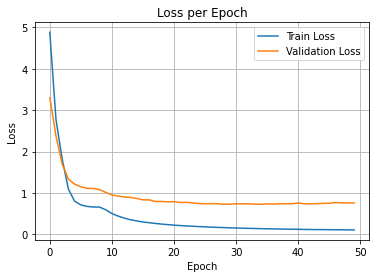

In [44]:
import matplotlib.pyplot as plt

EPOCHS = 50
train_losses = []
val_losses = []


sample_sentences = [
    "ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥.",
    "Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§.",
    "Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥.",
    "ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº."
]


for epoch in range(EPOCHS):
    total_train_loss = 0
    total_val_loss = 0

    # --- Training ---
    train_bar = tqdm(enumerate(train_dataset), total=tf.data.experimental.cardinality(train_dataset).numpy())
    for step, (enc_batch, dec_in_batch, dec_out_batch) in train_bar:
        batch_loss, _, _, _ = train_step(
            src=enc_batch,
            tgt=dec_in_batch,
            model=transformer,
            optimizer=optimizer
        )
        total_train_loss += batch_loss
        train_bar.set_description(f"Epoch {epoch + 1}")
        train_bar.set_postfix(train_loss=(total_train_loss.numpy() / (step + 1)))

    # --- Validation ---
    for val_enc_batch, val_dec_in_batch, val_dec_out_batch in val_dataset:
        enc_mask, dec_enc_mask, dec_mask = generate_masks(val_enc_batch, val_dec_in_batch)
        predictions, _, _, _ = transformer(val_enc_batch, val_dec_in_batch, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(val_dec_out_batch, predictions)
        total_val_loss += loss

    epoch_train_loss = total_train_loss.numpy() / tf.data.experimental.cardinality(train_dataset).numpy()
    epoch_val_loss = total_val_loss.numpy() / tf.data.experimental.cardinality(val_dataset).numpy()
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    # üî• Best model Ï†ÄÏû•
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        transformer.save_weights(save_path)
        print(f"‚úÖ Saved best model at Epoch {epoch + 1} (Val Loss: {best_val_loss:.4f})")

        
    print(f"\nüåÄ Epoch {epoch + 1}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    print("üìò Sample Responses:")
    for i, sentence in enumerate(sample_sentences, 1):
        try:
            print(f"{i}. {sentence} ‚Üí {evaluate(sentence)}")
        except Exception as e:
            print(f"{i}. {sentence} ‚Üí ‚ùå Error during inference: {e}")

# --- ÏãúÍ∞ÅÌôî ---
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per Epoch")
plt.grid(True)
plt.show()


## bpe

In [127]:
que_corpus, ans_corpus = aug_df['encoder'], aug_df['decoder']
ans_corpus = [f"<start> {sen.strip()} <end>" for sen in ans_corpus]
total_corpus = que_corpus + ans_corpus

In [128]:
with open("corpus.txt", "w", encoding="utf-8") as f:
    for line in total_corpus:
        f.write(line.strip() + "\n")

In [129]:
import sentencepiece as spm
spm.SentencePieceTrainer.Train(
    input='corpus.txt',
    model_prefix='spm_bpe',
    vocab_size=15000,
    model_type='bpe',
    user_defined_symbols=['<start>', '<end>'],
    character_coverage=0.9995
)

In [130]:
import sentencepiece as spm

sp = spm.SentencePieceProcessor()
sp.load('spm_bpe.model')


True

In [131]:
# Ïù∏ÏΩîÎî© (ÌÖçÏä§Ìä∏ ‚Üí ID ÏãúÌÄÄÏä§)
ids = sp.encode('<start> ÏïàÎÖïÌïòÏÑ∏Ïöî <end>', out_type=int)

# ÎîîÏΩîÎî© (ID ÏãúÌÄÄÏä§ ‚Üí ÌÖçÏä§Ìä∏)
text = sp.decode(ids)

# ÌÜ†ÌÅ∞ ÌôïÏù∏
tokens = sp.encode('<start> ÏïàÎÖïÌïòÏÑ∏Ïöî <end>', out_type=str)
print(tokens)

['‚ñÅ', '<start>', '‚ñÅÏïàÎÖï', 'Ìïò', 'ÏÑ∏Ïöî', '‚ñÅ', '<end>']


In [132]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LENGTH = 20

# Ï†ÑÏ≤¥ ÏßàÎ¨∏/ÎãµÎ≥Ä ÏãúÌÄÄÏä§
que_seq = [sp.encode(q, out_type=int) for q in que_corpus]
ans_seq = [sp.encode(f"<start> {a} <end>", out_type=int) for a in ans_corpus]

# Ìå®Îî©
enc_train = pad_sequences(que_seq, maxlen=MAX_LENGTH, padding='post')
ans_tensor = pad_sequences(ans_seq, maxlen=MAX_LENGTH, padding='post')

# ÎîîÏΩîÎçîÏö© ÏûÖÎ†•/Ï∂úÎ†•
dec_input = ans_tensor[:, :-1]
dec_target = ans_tensor[:, 1:]


In [133]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)
    tokens = sp.encode(sentence, out_type=int)
    encoder_input = tf.expand_dims(tokens, 0)

    start_id = sp.piece_to_id('<start>')
    end_id = sp.piece_to_id('<end>')
    output = tf.expand_dims([start_id], 0)

    for _ in range(MAX_LENGTH):
        enc_mask, dec_enc_mask, dec_mask = generate_masks(encoder_input, output)
        predictions, _, _, _ = transformer(encoder_input, output, enc_mask, dec_enc_mask, dec_mask)

        predicted_id = tf.argmax(predictions[:, -1:, :], axis=-1)
        predicted_id = tf.cast(predicted_id, tf.int32)

        if predicted_id[0][0].numpy() == end_id:
            break

        output = tf.concat([output, predicted_id], axis=-1)

    result = sp.decode(output.numpy().tolist()[0])
    return result.replace('<start>', '').replace('<end>', '').strip()


In [134]:
#train/val Î∂ÑÎ¶¨
from sklearn.model_selection import train_test_split

# Ïù∏ÏΩîÎçî ÏûÖÎ†•, ÎîîÏΩîÎçî ÏûÖÎ†•, ÎîîÏΩîÎçî Ï∂úÎ†•
enc_train, enc_val, dec_input_train, dec_input_val, dec_target_train, dec_target_val = train_test_split(
    enc_train, dec_input, dec_target, test_size=0.1, random_state=42)



import tensorflow as tf

BATCH_SIZE = 64
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_input_train, dec_target_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_input_val, dec_target_val))
val_dataset = val_dataset.batch(BATCH_SIZE)


In [135]:
import matplotlib.pyplot as plt

EPOCHS = 50
train_losses = []
val_losses = []


sample_sentences = [
    "ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥.",
    "Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§.",
    "Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥.",
    "ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº."
]


for epoch in range(EPOCHS):
    total_train_loss = 0
    total_val_loss = 0

    # --- Training ---
    train_bar = tqdm(enumerate(train_dataset), total=tf.data.experimental.cardinality(train_dataset).numpy())
    for step, (enc_batch, dec_in_batch, dec_out_batch) in train_bar:
        batch_loss, _, _, _ = train_step(
            src=enc_batch,
            tgt=dec_in_batch,
            model=transformer,
            optimizer=optimizer
        )
        total_train_loss += batch_loss
        train_bar.set_description(f"Epoch {epoch + 1}")
        train_bar.set_postfix(train_loss=(total_train_loss.numpy() / (step + 1)))

    # --- Validation ---
    for val_enc_batch, val_dec_in_batch, val_dec_out_batch in val_dataset:
        enc_mask, dec_enc_mask, dec_mask = generate_masks(val_enc_batch, val_dec_in_batch)
        predictions, _, _, _ = transformer(val_enc_batch, val_dec_in_batch, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(val_dec_out_batch, predictions)
        total_val_loss += loss

    epoch_train_loss = total_train_loss.numpy() / tf.data.experimental.cardinality(train_dataset).numpy()
    epoch_val_loss = total_val_loss.numpy() / tf.data.experimental.cardinality(val_dataset).numpy()
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    
    
      # üî• Best model Ï†ÄÏû•
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        transformer.save_weights(save_path)
        print(f"‚úÖ Saved best model at Epoch {epoch + 1} (Val Loss: {best_val_loss:.4f})")

        
    print(f"\nüåÄ Epoch {epoch + 1}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    print("üìò Sample Responses:")
    for i, sentence in enumerate(sample_sentences, 1):
        try:
            print(f"{i}. {sentence} ‚Üí {evaluate(sentence)}")
        except Exception as e:
            print(f"{i}. {sentence} ‚Üí ‚ùå Error during inference: {e}")

# --- ÏãúÍ∞ÅÌôî ---
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per Epoch")
plt.grid(True)
plt.show()

Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:32<00:00, 14.33it/s, train_loss=0.0834]



üåÄ Epoch 1, Train Loss: 0.0834, Val Loss: 0.5417
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí ÎπÑÏä∑ ÏùÄ Ï†ïÎßê Îì† Î©ãÏûà ÏùÑ Í±∞ ÏòàÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïñ∏Ï††Í∞Ñ Ïò¨ Ïû•Î©¥ Ïù¥ Ïóà ÏùÑ Í±∞ ÏòàÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Í∑∏ÎÉ• Ìó§Ïñ¥Ïßê ÏùÑ Ï£º Î©¥ Îì§ Ïñ¥ ÎìúÎ¶¥Í≤åÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí ÎÑàÌù¨ Ïù¥ ÎùºÎèÑ Îã¨Ïù¥ Î©¥ÏÑú Ï∂©Î∂Ñ Ìïú Ïù¥Í≥≥ ÏúºÎ°ú Í≤∏Ìïò Ïöî .


Epoch 2: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 459/459 [00:31<00:00, 14.40it/s, train_loss=0.0828]



üåÄ Epoch 2, Train Loss: 0.0828, Val Loss: 0.5452
üìò Sample Responses:
1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí Ï∂©Î∂ÑÌûà Ïûò Ìïò Í≥† Ïûà ÏùÑ Í±∞ ÏòàÏöî .
2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí Ïù¥Ï†ú ÏùºÏñ¥ÎÇ† Î∂ÑÍ∞Ñ Ïù¥ ÏóêÏöî .
3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí Ïñ¥Îñ§ Ïò§ ÎùºÍ≥† ÎßêÏîÄ Ìïò Îäî Í≤É ÎèÑ Ï¢ã ÏùÑ Í±∞ ÏòàÏöî .
4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí Î™∏Í∞í Ìïò Í≥† Îëò Îã§ Ï¶êÍ±∞Ïö¥ ÏùºÏ£ºÏùº Ïù¥ Í≤† ÎÑ§Ïöî .


Epoch 3:  34%|‚ñà‚ñà‚ñà‚ñç      | 157/459 [00:10<00:20, 14.45it/s, train_loss=0.0683]


KeyboardInterrupt: 

attention map

In [136]:
transformer.load_weights("best_model_weights.h5")

In [138]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# Ìè∞Ìä∏ Í≤ΩÎ°ú ÏÑ§Ï†ï - Colab ÏòàÏãú (Î°úÏª¨Ïù¥ÎùºÎ©¥ Í≤ΩÎ°ú ÏàòÏ†ï Í∞ÄÎä•)
# !apt-get -qq install -y fonts-nanum
# !fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
mpl.rcParams['font.family'] = 'NanumGothic'  # ÎòêÎäî 'Malgun Gothic', 'AppleGothic' Îì± OSÏóê ÎßûÍ≤å
mpl.rcParams['axes.unicode_minus'] = False  # ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ



üìù 1. ÏßÄÎ£®ÌïòÎã§, ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Ïñ¥. ‚Üí <start> <start> Ìó§Ïñ¥Ïßê Ïóê Î¨¥Îéå ÏßÄ ÏßÄ Ïïä Ï£† . <end> <end> <end> <end>


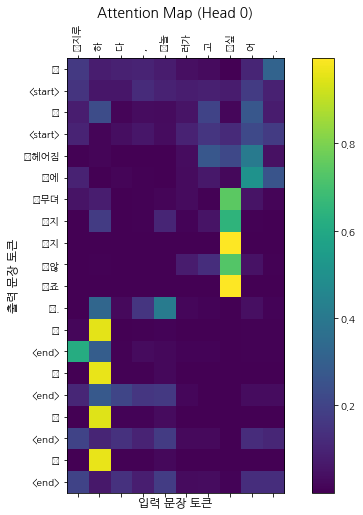

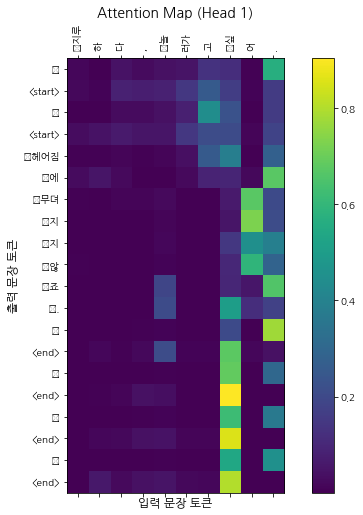


üìù 2. Ïò§Îäò ÏùºÏ∞ç ÏùºÏñ¥ÎÇ¨ÎçîÎãà ÌîºÍ≥§ÌïòÎã§. ‚Üí <start> <start> Ïñ∏Ï††Í∞Ñ Îã•Ï≥êÏò¨ ÏàúÍ∞Ñ Ïù¥ Ïóà ÏùÑ Í±∞ ÏòàÏöî . <end> <end> <end> 


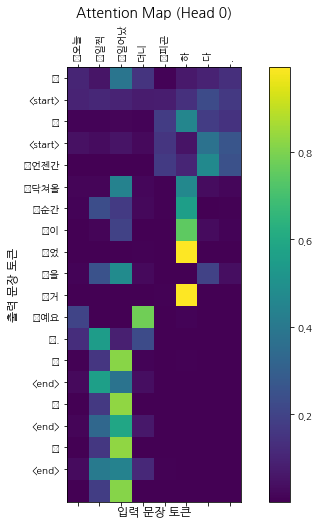

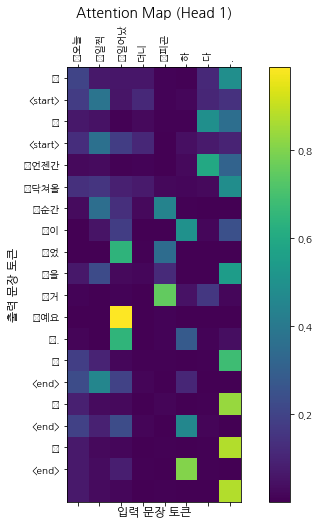


üìù 3. Í∞ÑÎßåÏóê Ïó¨ÏûêÏπúÍµ¨Îûë Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Î°ú ÌñàÏñ¥. ‚Üí <start> <start> Í∑∏ÎÉ• Îß§Ïùº Í∏∞ÏÅ® Ìï¥ÎèÑ Ïñ¥Î†µ Ïóà Í≤† Ïñ¥Ïöî . <end> <end> <end> 


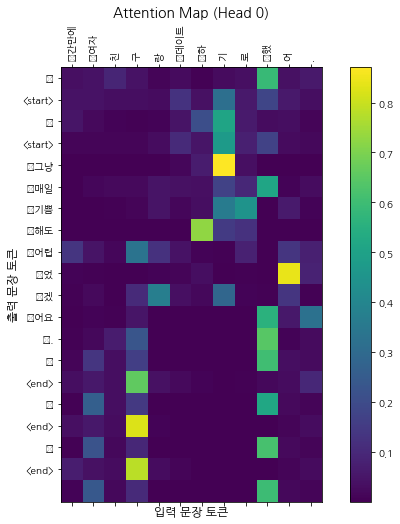

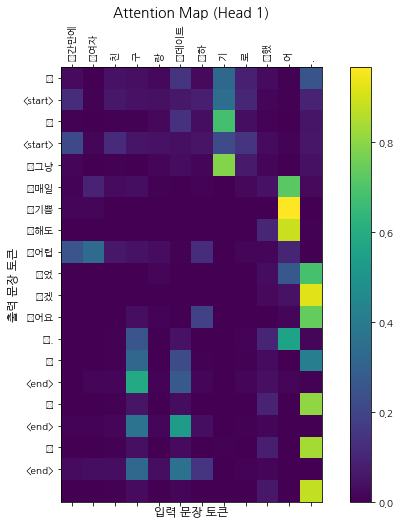


üìù 4. ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº. ‚Üí <start> <start> Ïñ¥ÎñªÍ≤å Îì† ÌùêÎ•¥ Î©¥ ÎèºÏöî . <end> <end> <end> <end> <end>


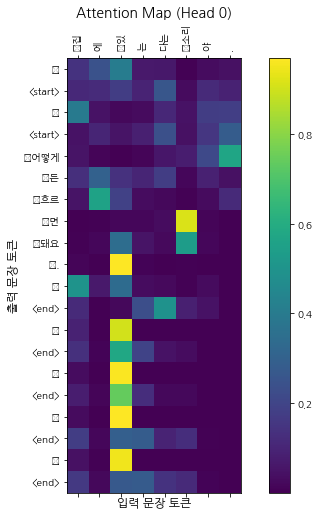

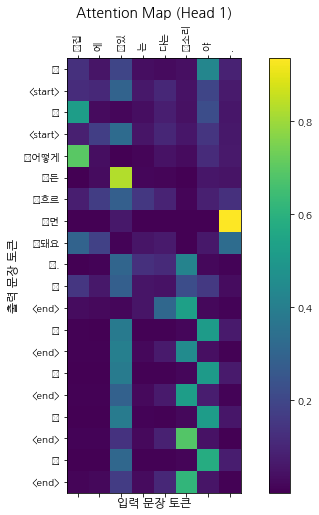

In [139]:
def plot_attention_map(attn, input_tokens, output_tokens, head=0):
    attn = attn[head]  # (tgt_len, src_len)
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(attn, cmap='viridis')
    
    ax.set_xticks(range(len(input_tokens)))
    ax.set_yticks(range(len(output_tokens)))
    ax.set_xticklabels(input_tokens, fontproperties="NanumGothic", rotation=90)
    ax.set_yticklabels(output_tokens, fontproperties="NanumGothic")
    
    plt.xlabel("ÏûÖÎ†• Î¨∏Ïû• ÌÜ†ÌÅ∞", fontsize=12)
    plt.ylabel("Ï∂úÎ†• Î¨∏Ïû• ÌÜ†ÌÅ∞", fontsize=12)
    plt.title(f"Attention Map (Head {head})", fontsize=14)
    plt.colorbar(cax)
    plt.show()


def evaluate(sentence):
    sentence = preprocess_sentence(sentence)
    encoder_input = tf.expand_dims(sp.encode(sentence, out_type=int), axis=0)
    output = tf.expand_dims([sp.bos_id()], 0)
    attention_weights = []

    for _ in range(MAX_LENGTH):
        enc_mask, dec_enc_mask, dec_mask = generate_masks(encoder_input, output)
        predictions, _, _, dec_enc_attns = transformer(encoder_input, output, enc_mask, dec_enc_mask, dec_mask)

        pred_id = tf.argmax(predictions[:, -1:, :], axis=-1)
        pred_id = tf.cast(pred_id, tf.int32)

        if pred_id.numpy()[0][0] == sp.eos_id():
            break

        output = tf.concat([output, pred_id], axis=-1)
        attention_weights.append(dec_enc_attns[-1][0])  # [batch, heads, tgt, src]

    decoded = sp.decode(tf.squeeze(output, axis=0).numpy().tolist())
    return decoded, attention_weights


for i, sentence in enumerate(sample_sentences, 1):
    try:
        response, attns = evaluate(sentence)
        print(f"\nüìù {i}. {sentence} ‚Üí {response}")

        input_tokens = sp.encode(sentence, out_type=str)
        output_tokens = sp.encode(response, out_type=str)

        last_attn = attns[-1].numpy()  # ÎßàÏßÄÎßâ ÎîîÏΩîÎî© stepÏùò attention (heads, tgt_len, src_len)

        for head in range(min(2, last_attn.shape[0])):  # ÏµúÎåÄ 2Í∞ú headÎßå ÏãúÍ∞ÅÌôî
            plot_attention_map(last_attn, input_tokens, output_tokens, head=head)

    except Exception as e:
        print(f"‚ùå Error during attention visualization: {e}")


- Ï∂úÎ†• ÌÜ†ÌÅ∞Í≥º ÏûÖÎ†• ÌÜ†ÌÅ∞Ïùò attention mapÏùÑ ÏÇ¥Ìé¥Î≥¥Î©¥ 
- Ï∂úÎ†•ÌÜ†ÌÅ∞Îì§Ïù¥ ÏùòÎØ∏ÏÉÅ Ï§ëÏöîÌïú ÏûÖÎ†• ÌÜ†ÌÅ∞Ïóê Ï∂©Î∂ÑÌïú attentionÏùÑ Ï£ºÏßÄ ÏïäÎäî Í≤ÉÏ≤òÎüº Î≥¥Ïù∏Îã§. 
- ÌÜ†ÌÅ∞Îì§Ïù¥ ÏûÖÎ†•Ïùò ÌïµÏã¨Îã®Ïñ¥Ïóê ÏßëÏ§ëÌïòÏßÄ ÏïäÍ≥† Î∂ÑÏÇ∞Îêú attentionÏùÑ Î≥¥ÏûÑ

# ÏÑ±Îä• Ï∏°Ï†ïÌïòÍ∏∞
- BLEU, Perplexity, Rouge
- calculate_bleu()

In [58]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [59]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function Ï†ÅÏö©


In [60]:
def translate(tokens, model, src_tokenizer, tgt_tokenizer):
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)   
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)  
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)  
    return result

print("Ïäù=3")

Ïäù=3


In [61]:
MAX_LEN = 20  # Î™®Îç∏ ÏûÖÎ†• ÏãúÌÄÄÏä§ ÏµúÎåÄ Í∏∏Ïù¥
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    src_tokens = src_tokenizer.encode_as_ids(src_sentence)
    tgt_tokens = tgt_tokenizer.encode_as_ids(tgt_sentence)

    if (len(src_tokens) > MAX_LEN): return None
    if (len(tgt_tokens) > MAX_LEN): return None

    reference = tgt_sentence.split()
    candidate = translate(src_tokens, model, src_tokenizer, tgt_tokenizer).split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score
        
print('Ïäù=3')

Ïäù=3


In [62]:
# # Q. Ïù∏Îç±Ïä§Î•º Î∞îÍøîÍ∞ÄÎ©∞ ÌÖåÏä§Ìä∏Ìï¥ Î≥¥ÏÑ∏Ïöî
# test_idx = 20

# eval_bleu_single(transformer, 
#                  test_eng_sentences[test_idx], 
#                  test_spa_sentences[test_idx], 
#                  tokenizer, 
#                  tokenizer)

In [63]:
def eval_bleu(model, src_sentences, tgt_sentences, src_tokenizer, tgt_tokenizer, verbose=True):    
    total_score = 0.0
    sample_size = len(src_sentences)

    for idx in tqdm(range(sample_size)):
        src = src_sentences.iloc[idx] if isinstance(src_sentences, pd.Series) else src_sentences[idx]
        tgt = tgt_sentences.iloc[idx] if isinstance(tgt_sentences, pd.Series) else tgt_sentences[idx]

        score = eval_bleu_single(model, src, tgt, src_tokenizer, tgt_tokenizer, verbose)
        if not score:
            continue
        total_score += score

    print("Num of Sample:", sample_size)
    print("Average BLEU Score:", total_score / sample_size)

    
print("Ïäù=3")

Ïäù=3


In [64]:
# ÏõêÎ¨∏ÏóêÏÑú Îã§Ïãú Î∂ÑÎ¶¨
src_train_sentences, src_val_sentences, tgt_train_sentences, tgt_val_sentences = train_test_split(
    que_corpus, ans_corpus, test_size=0.1, random_state=42
)

# <start>, <end> Ï†úÍ±∞
tgt_val_sentences = [s.replace('<start>', '').replace('<end>', '').strip() for s in tgt_val_sentences]


- BLEU ÌèâÍ∑†Ï†êÏàò : 0.2146
- Í∏∞Ï¥àÏ†ÅÏù∏ Íµ¨Ï°∞Ïùò ÏùëÎãµÏùÑ ÌïòÏßÄÎßå Ïñ¥Ìúò Îã§ÏñëÏÑ±Ïù¥ Î∂ÄÏ°±ÌïòÎã§. 

In [65]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

def eval_bleu_with_examples(model, src_sentences, tgt_sentences, src_tokenizer, tgt_tokenizer, num_examples=5):
    total_score = 0.0
    sample_size = len(src_sentences)
    smooth_fn = SmoothingFunction().method4

    print("üß™ BLEU ÌèâÍ∞Ä ÏãúÏûë...")
    for idx in tqdm(range(sample_size)):
        src = src_sentences.iloc[idx] if isinstance(src_sentences, pd.Series) else src_sentences[idx]
        ref = tgt_sentences.iloc[idx] if isinstance(tgt_sentences, pd.Series) else tgt_sentences[idx]


        # Ïù∏ÌçºÎü∞Ïä§
        try:
            # üîß Ïó¨Í∏∞ ÏàòÏ†ï: Ïã§Ï†ú ÌèâÍ∞Ä Ìï®Ïàò ÏÇ¨Ïö©
            hyp = evaluate(src)

            score = sentence_bleu(
                [ref.split()],
                hyp.split(),
                smoothing_function=SmoothingFunction().method1
            )
            total_score += score

            if idx < num_examples:
                print(f"\nüìå ÏòàÏãú {idx + 1}")
                print(f"üëâ ÏûÖÎ†•:     {src}")
                print(f"‚úÖ Ï†ïÎãµ:     {ref}")
                print(f"üß† ÏòàÏ∏°:     {hyp}")
                print(f"üéØ BLEU:     {score:.4f}")
        except Exception as e:
            print(f"‚ùå Ïò§Î•ò Î∞úÏÉù at index {idx}: {e}")
            continue

    print(f"\nüîö Num of Samples: {sample_size}")
    print(f"üìä Average BLEU Score: {total_score / sample_size:.4f}")

In [66]:
eval_bleu_with_examples(
    model=transformer,
    src_sentences=src_val_sentences,
    tgt_sentences=tgt_val_sentences,
    src_tokenizer=sp,
    tgt_tokenizer=sp,
    num_examples=5  # ÏÉÅÏúÑ 5Í∞ú ÏòàÏãú Ï∂úÎ†•
)


üß™ BLEU ÌèâÍ∞Ä ÏãúÏûë...


  0%|          | 1/3265 [00:00<51:05,  1.06it/s]


üìå ÏòàÏãú 1
üëâ ÏûÖÎ†•:     Ïù¥ Î≥ÑÌõÑ ÎäêÎÅº Îäî Í∞êÏ†ï Îì§ Ïù¥ Îã®Í≥Ñ Î≥Ñ Î°ú Ïûà Îäî Í±∞ Í∞ô ÎÑ§
‚úÖ Ï†ïÎãµ:     Í∑∏Í≤å Ï∂îÏñµ Ïùò Ïú†Ï†Å Ïù∏Í∞Ä Î¥êÏöî .
üß† ÏòàÏ∏°:     Í∑∏Í≤å Ï∂îÏñµ Ïùò Î™®Ïäµ Í≥º Ìï®Íªò Ïóê ÎåÄÌïú ÏãúÍ∞Ñ Ïù¥ Ïóà Îã§Î©¥ Î≥ÄÌôî Í∞Ä Î™Ö ÏúºÎãàÍπåÏöî .
üéØ BLEU:     0.0612


  0%|          | 2/3265 [00:01<49:11,  1.11it/s]


üìå ÏòàÏãú 2
üëâ ÏûÖÎ†•:     Í∞ÑÏãù Ìè¥Îçî ÎΩë Îäî Í±∞ ÌûòÎìú ÎÑ§
‚úÖ Ï†ïÎãµ:     ÎàÑÍµ¨ Îûë Î®π Îäî ÎÉê Ïóê Îî∞Îùº Îã§Î•¥ Í≤† Ï£† .
üß† ÏòàÏ∏°:     Ïä¨Ìîî Ìïò Í∏∞ ÎèÑ ÏãúÌÇ§ ÏßÄ Ïïä Îäî ÏïΩÍ∞Ñ Ïùò Î∞©Ïãù Ïù¥ ÏóêÏöî .
üéØ BLEU:     0.0170


  0%|          | 3/3265 [00:02<40:00,  1.36it/s]


üìå ÏòàÏãú 3
üëâ ÏûÖÎ†•:     Ïó∞Ïï† Ï§ë Ïù∏Îç∞ Ïô∏Î°úÏö¥ ÎäêÎÇå Ïù¥ Îì§ Î©¥ Î¨∏Ï†ú ÏùºÍπå ?
‚úÖ Ï†ïÎãµ:     ÏÇ¨Îûå ÏùÄ Îã§ Ïô∏Î°úÏö¥ Ï°¥Ïû¨ ÏòàÏöî .
üß† ÏòàÏ∏°:     Ï†äÏùÄÏù¥ ÏùÄ Îã§ Ïô∏Î°úÏö¥ ÌòÑÏ°¥ ÏòàÏöî .
üéØ BLEU:     0.2056


  0%|          | 4/3265 [00:02<34:28,  1.58it/s]


üìå ÏòàÏãú 4
üëâ ÏûÖÎ†•:     Ïù¥Îü∞ Ìó§Ïñ¥ÏßÄ
‚úÖ Ï†ïÎãµ:     ÌùîÌïò ÏßÄ Ïïä Ï£† .
üß† ÏòàÏ∏°:     Î™®Î•¥ Îã§Í∞Ä ÎèÑ Ïïà ÎèºÏöî .
üéØ BLEU:     0.0408


  0%|          | 5/3265 [00:03<34:57,  1.55it/s]


üìå ÏòàÏãú 5
üëâ ÏûÖÎ†•:     Í∞ïÏïÑÏßÄ ÌÇ§Ïö∞ Í≥† Ïã∂ Ïñ¥
‚úÖ Ï†ïÎãµ:     Ï£ÑÏ±Ö Ïßà Ïàò ÏóÜ ÏùÑ Í≤ΩÏö∞ ÌÇ§Ïõå Î≥¥ ÏÑ∏Ïöî .
üß† ÏòàÏ∏°:     Í≥ºÏã§ Ïßà Ïàò ÏóÜÏóà ÏùÑ ÎïåÏØ§ ÌÇ§Ïõå Î≥¥ ÏÑ∏Ïöî .
üéØ BLEU:     0.3247


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3265/3265 [32:59<00:00,  1.65it/s]


üîö Num of Samples: 3265
üìä Average BLEU Score: 0.4123


- average bleu score : 0.4123
- ÏàòÏπòÏ†ÅÏúºÎ°ú Î≥¥ÏïòÏùÑ ÎïåÎäî Í¥úÏ∞ÆÏùÄ ÌíàÏßàÏùò ÎãµÎ≥ÄÏùÑ ÌïòÎäî Í≤ÉÏúºÎ°ú Î≥¥Ïù¥ÏßÄÎßå
- Ïã§Ï†ú ÏòàÏ∏°ÏùÑ Î≥¥Î©¥ Î¨∏Î≤ïÏ†Å Î∂ÄÏûêÏó∞ Ïä§Îü¨ÏõÄÏù¥ÎÇò Ïñ¥Ìúò ÏÑ†ÌÉùÏù¥ Ïñ¥ÏÉâÌïú Í≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§. 


## Perplexity

In [67]:
!pip install rouge-score
!pip install evaluate

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=479e1d480bae4f7c7fb023bda6915662077139dc679f84eb109773275e1e3453
  Stored in directory: /aiffel/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge-score
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84 kB 2.1 MB/s             
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 489 kB 50.5 MB/s            
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 491 kB 74.8 MB/s            
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 193 kB 74.2 MB/s            
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 64 kB 754 kB/s          

In [69]:
!pip uninstall pyarrow -y
!pip install pyarrow --upgrade
!pip uninstall datasets evaluate -y
!pip install datasets evaluate

Found existing installation: pyarrow 20.0.0
Uninstalling pyarrow-20.0.0:
  Successfully uninstalled pyarrow-20.0.0
  Using cached pyarrow-20.0.0-cp39-cp39-manylinux_2_28_x86_64.whl (42.3 MB)
Found existing installation: datasets 3.6.0
Uninstalling datasets-3.6.0:
  Successfully uninstalled datasets-3.6.0
Found existing installation: evaluate 0.4.3
Uninstalling evaluate-0.4.3:
  Successfully uninstalled evaluate-0.4.3
  Using cached datasets-3.6.0-py3-none-any.whl (491 kB)
  Using cached evaluate-0.4.3-py3-none-any.whl (84 kB)


In [78]:
import numpy as np
# import evaluate
from tqdm import tqdm

import numpy as np

def compute_perplexity(model, val_dataset, loss_function):
    total_loss = 0.0
    total_tokens = 0

    for enc_batch, dec_in_batch, dec_out_batch in val_dataset:
        enc_mask, dec_enc_mask, dec_mask = generate_masks(enc_batch, dec_in_batch)
        predictions, _, _, _ = model(enc_batch, dec_in_batch, enc_mask, dec_enc_mask, dec_mask)
        
        loss = loss_function(dec_out_batch, predictions)
        token_count = tf.reduce_sum(tf.cast(dec_out_batch != 0, tf.float32)).numpy()
        
        total_loss += loss.numpy() * token_count
        total_tokens += token_count

    perplexity = np.exp(total_loss / total_tokens)
    print(f"üß† Perplexity (PPL): {perplexity:.4f}")
    return perplexity
compute_perplexity(transformer, val_dataset, loss_function)

üß† Perplexity (PPL): 1.9602


1.9602383136784436

In [85]:
def lcs(X, Y):
    m, n = len(X), len(Y)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m):
        for j in range(n):
            if X[i] == Y[j]:
                dp[i+1][j+1] = dp[i][j] + 1
            else:
                dp[i+1][j+1] = max(dp[i][j+1], dp[i+1][j])
    return dp[m][n]

def rouge_l_score(reference, hypothesis):
    ref_tokens = reference.split()
    hyp_tokens = hypothesis.split()
    
    lcs_len = lcs(ref_tokens, hyp_tokens)

    prec = lcs_len / len(hyp_tokens) if hyp_tokens else 0.0
    rec = lcs_len / len(ref_tokens) if ref_tokens else 0.0
    if prec + rec == 0:
        f1 = 0.0
    else:
        f1 = 2 * prec * rec / (prec + rec)
    
    return {"precision": prec, "recall": rec, "f1": f1}


In [86]:
import numpy as np
from tqdm import tqdm

# ‚úÖ ROUGE-L Í≥ÑÏÇ∞ Ìï®Ïàò (ÏÑ§Ïπò ÌïÑÏöî ÏóÜÏùå)
def rouge_l_score(reference, hypothesis):
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    ref_len = len(ref_words)
    hyp_len = len(hyp_words)

    # LCS (ÏµúÏû• Í≥µÌÜµ Î∂ÄÎ∂Ñ ÏàòÏó¥)
    lcs_matrix = [[0] * (hyp_len + 1) for _ in range(ref_len + 1)]

    for i in range(ref_len):
        for j in range(hyp_len):
            if ref_words[i] == hyp_words[j]:
                lcs_matrix[i+1][j+1] = lcs_matrix[i][j] + 1
            else:
                lcs_matrix[i+1][j+1] = max(lcs_matrix[i][j+1], lcs_matrix[i+1][j])

    lcs_len = lcs_matrix[-1][-1]

    recall = lcs_len / ref_len if ref_len > 0 else 0.0
    precision = lcs_len / hyp_len if hyp_len > 0 else 0.0
    f1 = 2 * recall * precision / (recall + precision + 1e-8)
    return f1


In [87]:
def compute_perplexity(model, val_dataset, loss_function):
    total_loss = 0.0
    total_tokens = 0

    for enc_batch, dec_in_batch, dec_out_batch in val_dataset:
        enc_mask, dec_enc_mask, dec_mask = generate_masks(enc_batch, dec_in_batch)
        predictions, _, _, _ = model(enc_batch, dec_in_batch, enc_mask, dec_enc_mask, dec_mask)
        mask = tf.cast(dec_out_batch != 0, tf.float32)
        loss = loss_function(dec_out_batch, predictions)
        total_loss += loss.numpy() * tf.reduce_sum(mask).numpy()
        total_tokens += tf.reduce_sum(mask).numpy()

    perplexity = np.exp(total_loss / total_tokens)
    print(f"\nüß† Perplexity (PPL): {perplexity:.4f}")
    return perplexity


In [88]:
from tqdm import tqdm

def evaluate_rouge(model, src_sentences, tgt_sentences, tokenizer, num_examples=5):
    total_rouge = 0.0
    count = 0

    print("üß™ ROUGE-L ÌèâÍ∞Ä ÏãúÏûë...\n")

    for idx in tqdm(range(len(src_sentences))):
        src = src_sentences.iloc[idx] if isinstance(src_sentences, pd.Series) else src_sentences[idx]
        ref = tgt_sentences.iloc[idx] if isinstance(tgt_sentences, pd.Series) else tgt_sentences[idx]


        try:
            hyp = evaluate(src)  # üîß ÏÇ¨Ïö©Ïûê Ï†ïÏùò ÏòàÏ∏° Ìï®Ïàò
            rouge = rouge_l_score(ref, hyp)
            total_rouge += rouge
            count += 1

            if idx < num_examples:
                print(f"\nüìå ÏòàÏãú {idx + 1}")
                print(f"üëâ ÏûÖÎ†•:  {src}")
                print(f"‚úÖ Ï†ïÎãµ:  {ref}")
                print(f"üß† ÏòàÏ∏°:  {hyp}")
                print(f"üìè ROUGE-L F1: {rouge:.4f}")

        except Exception as e:
            print(f"‚ùå Ïò§Î•ò at {idx}: {e}")
            continue

    print("\nüìä ÏµúÏ¢Ö Í≤∞Í≥º")
    print(f"‚úÖ ÌèâÍ∑† ROUGE-L F1: {total_rouge / count:.4f}")


In [89]:
# ROUGE-L Í≥ÑÏÇ∞
evaluate_rouge(
    model=transformer,
    src_sentences=src_val_sentences,
    tgt_sentences=tgt_val_sentences,
    tokenizer=sp,  # SentencePiece tokenizer
    num_examples=5
)

# Perplexity Í≥ÑÏÇ∞
compute_perplexity(
    model=transformer,
    val_dataset=val_dataset,
    loss_function=loss_function
)


üß™ ROUGE-L ÌèâÍ∞Ä ÏãúÏûë...



  0%|          | 1/3265 [00:00<51:41,  1.05it/s]


üìå ÏòàÏãú 1
üëâ ÏûÖÎ†•:  Ïù¥ Î≥ÑÌõÑ ÎäêÎÅº Îäî Í∞êÏ†ï Îì§ Ïù¥ Îã®Í≥Ñ Î≥Ñ Î°ú Ïûà Îäî Í±∞ Í∞ô ÎÑ§
‚úÖ Ï†ïÎãµ:  Í∑∏Í≤å Ï∂îÏñµ Ïùò Ïú†Ï†Å Ïù∏Í∞Ä Î¥êÏöî .
üß† ÏòàÏ∏°:  Í∑∏Í≤å Ï∂îÏñµ Ïùò Î™®Ïäµ Í≥º Ìï®Íªò Ïóê ÎåÄÌïú ÏãúÍ∞Ñ Ïù¥ Ïóà Îã§Î©¥ Î≥ÄÌôî Í∞Ä Î™Ö ÏúºÎãàÍπåÏöî .
üìè ROUGE-L F1: 0.3333


  0%|          | 2/3265 [00:01<49:46,  1.09it/s]


üìå ÏòàÏãú 2
üëâ ÏûÖÎ†•:  Í∞ÑÏãù Ìè¥Îçî ÎΩë Îäî Í±∞ ÌûòÎìú ÎÑ§
‚úÖ Ï†ïÎãµ:  ÎàÑÍµ¨ Îûë Î®π Îäî ÎÉê Ïóê Îî∞Îùº Îã§Î•¥ Í≤† Ï£† .
üß† ÏòàÏ∏°:  Ïä¨Ìîî Ìïò Í∏∞ ÎèÑ ÏãúÌÇ§ ÏßÄ Ïïä Îäî ÏïΩÍ∞Ñ Ïùò Î∞©Ïãù Ïù¥ ÏóêÏöî .
üìè ROUGE-L F1: 0.1600


  0%|          | 3/3265 [00:02<40:23,  1.35it/s]


üìå ÏòàÏãú 3
üëâ ÏûÖÎ†•:  Ïó∞Ïï† Ï§ë Ïù∏Îç∞ Ïô∏Î°úÏö¥ ÎäêÎÇå Ïù¥ Îì§ Î©¥ Î¨∏Ï†ú ÏùºÍπå ?
‚úÖ Ï†ïÎãµ:  ÏÇ¨Îûå ÏùÄ Îã§ Ïô∏Î°úÏö¥ Ï°¥Ïû¨ ÏòàÏöî .
üß† ÏòàÏ∏°:  Ï†äÏùÄÏù¥ ÏùÄ Îã§ Ïô∏Î°úÏö¥ ÌòÑÏ°¥ ÏòàÏöî .
üìè ROUGE-L F1: 0.7143


  0%|          | 4/3265 [00:02<34:52,  1.56it/s]


üìå ÏòàÏãú 4
üëâ ÏûÖÎ†•:  Ïù¥Îü∞ Ìó§Ïñ¥ÏßÄ
‚úÖ Ï†ïÎãµ:  ÌùîÌïò ÏßÄ Ïïä Ï£† .
üß† ÏòàÏ∏°:  Î™®Î•¥ Îã§Í∞Ä ÎèÑ Ïïà ÎèºÏöî .
üìè ROUGE-L F1: 0.1818


  0%|          | 5/3265 [00:03<35:47,  1.52it/s]


üìå ÏòàÏãú 5
üëâ ÏûÖÎ†•:  Í∞ïÏïÑÏßÄ ÌÇ§Ïö∞ Í≥† Ïã∂ Ïñ¥
‚úÖ Ï†ïÎãµ:  Ï£ÑÏ±Ö Ïßà Ïàò ÏóÜ ÏùÑ Í≤ΩÏö∞ ÌÇ§Ïõå Î≥¥ ÏÑ∏Ïöî .
üß† ÏòàÏ∏°:  Í≥ºÏã§ Ïßà Ïàò ÏóÜÏóà ÏùÑ ÎïåÏØ§ ÌÇ§Ïõå Î≥¥ ÏÑ∏Ïöî .
üìè ROUGE-L F1: 0.7000


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3265/3265 [33:05<00:00,  1.64it/s]



üìä ÏµúÏ¢Ö Í≤∞Í≥º
‚úÖ ÌèâÍ∑† ROUGE-L F1: 0.6708

üß† Perplexity (PPL): 1.9602


1.960238318502801

# Í≤∞Í≥º Ï†ïÎ¶¨
- dropoutÏùÑ 0.3->0.5Î°ú Ìï† Îïå Î≥ÄÌôîÍ∞Ä ÎààÏóê ÎùÑÎäîÎç∞,
0.3Ïùº ÎïåÎäî Í∏∏Í≥† ÏïàÏ†ïÏ†ÅÏù∏ Î¨∏Ïû•ÏùÑ Î±âÎäî Î∞òÎ©¥
0.5Ïùº ÎïåÎäî ÏßßÍ≥† ÏùòÎØ∏ÏóÜÎäî Î¨∏Ïû•ÏùÑ Î±âÎäî Í≤ΩÏö∞Í∞Ä ÎßéÏïòÏäµÎãàÎã§.
[SRC]  ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº.
[GEN]:  ['<start>', 'ÏÑ∏Ïöî', '.<end>']
[TGT]  ['Ï¢ã', 'ÏïÑ', 'Ìïò', 'Î©¥', 'Í∑∏Îü¥', 'Ïàò', 'Ïûà', 'Ïñ¥Ïöî', '.']
[SRC]  ÏßëÏóê ÏûàÎäîÎã§Îäî ÏÜåÎ¶¨Ïïº.
[GEN]:  ['<start>', 'ÏßÄÏºú', 'Ï£º', 'ÏÑ∏Ïöî', '.<end>']
[TGT]  ['Ï¢ã', 'ÏïÑ', 'Ìïò', 'Î©¥', 'Í∑∏Îü¥', 'Ïàò', 'Ïûà', 'Ïñ¥Ïöî', '.']
- augmentation Ìï† Îïå ÏùòÎØ∏Í∞Ä ÎπÑÏä∑Ìïú Í≤ÉÏúºÎ°ú Îã®Ïñ¥Î•º ÎåÄÏ≤¥ÌïòÎã§Î≥¥Îãà ÏòàÏ∏°Ìïú ÎãµÎ≥ÄÎèÑ Îã®Ïñ¥Î•º ÎåÄÏ≤¥Ìï¥ÏÑú ÎßåÎì§Ïñ¥ÏßÑ Î¨∏Ïû•Ïù¥ ÎßéÎã§. 
- Í∑∏Î†áÎã§Î≥¥Îãà Î¨∏Î≤ïÏ†ÅÏúºÎ°ú Ïñ¥ÏÉâÌïú Î¨∏Ïû•Ïù¥ ÎßéÏùÄ Í≤É Í∞ôÎã§. 
- Îç∞Ïù¥ÌÑ∞Í∞Ä 3ÎßåÍ∞ú Ï†ïÎèÑÎ°ú Ï†ÅÎã§ Î≥¥Îãà Ï†ïÏÑ±Ï†ÅÏúºÎ°ú Î≥¥ÎÇò Ï†ïÎüâÏ†ÅÏúºÎ°ú Î≥¥ÎÇò ÏïÑÏâ¨Ïö¥ Í≤∞Í≥ºÎ•º ÏñªÏùÄ Í≤É Í∞ôÎã§. 
- augmentation ÌïòÎäî Î∞©ÏãùÏùÑ Îã§ÏñëÌïòÍ≤å ÏãúÎèÑÌï¥Î≥¥Î©¥ Ï¢ÄÎçî ÌïôÏäµÏù¥ Ïûò ÎêòÏßÄ ÏïüÏùÑÍπå ÏÉùÍ∞ÅÏù¥ ÎêúÎã§. 
- epochÏàòÎäî 10ÏùÑ ÎÑòÏßÄ ÏïäÎäîÍ≤ÉÏù¥ Í≥ºÏ†ÅÌï©ÎêòÏßÄ ÏïäÎäîÍ≤É Í∞ôÎã§. 

# ÌöåÍ≥†
- Í≥ºÎåÄÏ†ÅÌï©ÏùÑ ÎßâÍ∏∞ÏúÑÌï¥ d_ff =[2048, 1024], dropout = [0.3, 0.5]Î°ú Ïã§ÌóòÏùÑ ÌïòÏòÄÏúºÎÇò Ï≤òÏùå ÎßåÎì† baseline Î™®Îç∏Ïù¥ Îçî Ï¢ãÏùÄ Í≤∞Í≥ºÍ∞Ä ÎÇòÏôîÎã§. (Ï†ïÏÑ±Ï†Å ÌèâÍ∞ÄÎ°ú ÏòàÎ¨∏ Ï∂úÎ†•ÏùÑ ÌôïÏù∏ÌñàÏùÑ Îïå)
- dropout 0.5Ïù∏ Í≤ΩÏö∞ ÏßßÍ≥† ÏùòÎØ∏ ÏóÜÎäî Î¨∏Ïû•ÏùÑ ÏÉùÏÑ±ÌïòÏòÄÎã§.  

    " ÏÑ∏Ïöî . '
    " ÏóêÏöî . '
